In [1]:
from __future__ import print_function, division
import os
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tqdm
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from tensorflow.python.client import device_lib; device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9825891864665755047, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16197660024208121208
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13547798760362097201
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14254804173
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9177881750564024453
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
import tarfile
fname = 'data.tar.gz'
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [0]:
class DenoisingDataset(Dataset):

    def __init__(self, data_dir, transform=None, train=True, val=False, val_size=0.2):
        self.train= train 
        self.x_path = os.path.join(data_dir, 'distorted')
        self.y_path = os.path.join(data_dir, 'clean')
        self.x_test_path = os.path.join(data_dir, 'test_distorted')
        self.x_files_paths = glob.glob(os.path.join(self.x_path, '*.jpg'))
        self.y_files_paths = glob.glob(os.path.join(self.y_path, '*.jpg'))
#         self.x_train_paths, self.x_val_paths, self.y_train_paths, self.y_val_paths = train_test_split(
#             self.x_files_paths, self.y_files_paths, test_size=val_size, random_state=42)
        self.x_test_files_paths = glob.glob(os.path.join(self.x_test_path, '*.jpg'))
        self.transform = transform
        self.train_data = []
#         self.val_data = []
#         self.val_labels_data = []
        self.test_data = []
        self.labels_data = []
#         self.val = val

    def __len__(self):
        if self.train:
            return len(self.x_files_paths)
        else:
            return len(self.x_test_files_paths)

    def __getitem__(self, idx):
#         if self.val:
#             x_img_name, y_img_name =  self.x_files_paths[idx], self.y_files_paths[idx]
#             x_image, y_image = io.imread(x_img_name), io.imread(y_img_name)
#             x = self.transform(x_image)
#             y = self.transform(y_image)
#             self.val_data.append(x)
#             self.val_labels_data.append(y)
#             return x,y
          
        if self.train: 
            x_img_name, y_img_name =  self.x_files_paths[idx], self.y_files_paths[idx]
            x_image, y_image = io.imread(x_img_name), io.imread(y_img_name)
            x = self.transform(x_image)
            y = self.transform(y_image)
            self.train_data.append(x)
            self.labels_data.append(y)
            return x,y
            
        else:
            x_test_img_name =  self.x_test_files_paths[idx]
            x_test_image = io.imread(x_test_img_name)
            x = self.transform(x_test_image)
            self.test_data.append(x)
            return x
        
    def get_train_data(self, num):
        return torch.stack(self.train_data[:num]), torch.stack(self.labels_data[:num])
    def get_val_data(self, num):
        return torch.stack(self.val_data[:num]), torch.stack(self.val_labels_data[:num])
    
    def get_test_data(self, num):
        return torch.stack(self.test_data[:num])

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
      
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 64, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            
            nn.Conv2d(64, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
 
            
        )
        self.out = nn.Sigmoid()

        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(32, 64, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(64, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(32, 3, (3, 3), padding=1),
#             nn.ReLU(inplace=True),
            
        )

    def forward(self, x):
        residual = x
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded + residual
        decoded = self.out(decoded)
        
        return encoded, decoded


In [0]:
class REDNet10(nn.Module):
    def __init__(self, num_layers=5, num_features=64):
        super(REDNet10, self).__init__()
        conv_layers = []
        deconv_layers = []

        conv_layers.append(nn.Sequential(nn.Conv2d(3, num_features, kernel_size=3, stride=2, padding=1),
                                         nn.ReLU(inplace=True)))
        for i in range(num_layers - 1):
            conv_layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                             nn.ReLU(inplace=True)))

        for i in range(num_layers - 1):
            deconv_layers.append(nn.Sequential(nn.ConvTranspose2d(num_features, num_features, kernel_size=3, padding=1),
                                               nn.ReLU(inplace=True)))
        deconv_layers.append(nn.ConvTranspose2d(num_features, 3, kernel_size=3, stride=2, padding=1, output_padding=1))

        self.conv_layers = nn.Sequential(*conv_layers)
        self.deconv_layers = nn.Sequential(*deconv_layers)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
#         residual = x
        out = self.conv_layers(x)
        out = self.deconv_layers(out)
#         out += residual
        out = self.relu(out)
        return out


In [6]:
# Hyper Parameters
epochs = 16
lr = 0.005
n_plots = 1
batch_size = 32
torch.manual_seed(42)

torch.Size([32, 3, 48, 48])
tensor([[[0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8314, 0.8314],
         [0.8314, 0.8314, 0.8392,  ..., 0.8510, 0.8431, 0.8431],
         [0.8353, 0.8392, 0.8431,  ..., 0.8510, 0.8471, 0.8431],
         ...,
         [0.2510, 0.2510, 0.2510,  ..., 0.3098, 0.3098, 0.3098],
         [0.0667, 0.0667, 0.0667,  ..., 0.0588, 0.0588, 0.0588],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8118, 0.8157, 0.8196,  ..., 0.8863, 0.8784, 0.8784],
         [0.8157, 0.8157, 0.8235,  ..., 0.8941, 0.8863, 0.8863],
         [0.8196, 0.8235, 0.8275,  ..., 0.8941, 0.8902, 0.8863],
         ...,
         [0.3255, 0.3255, 0.3255,  ..., 0.3843, 0.3843, 0.3843],
         [0.1412, 0.1412, 0.1412,  ..., 0.1333, 0.1333, 0.1333],
         [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157]],

        [[0.7961, 0.8000, 0.8039,  ..., 0.8471, 0.8392, 0.8392],
         [0.8039, 0.8039, 0.8118,  ..., 0.8627, 0.8549, 0.8549],
         [0.8078, 0.8118, 0.81

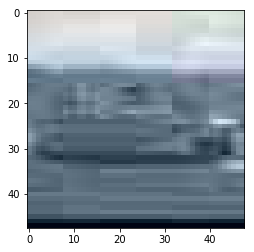

tensor([[[0.8039, 0.7922, 0.8000,  ..., 0.8706, 0.8824, 0.9020],
         [0.7843, 0.7765, 0.7922,  ..., 0.8588, 0.8549, 0.8784],
         [0.7882, 0.7843, 0.7882,  ..., 0.8510, 0.8392, 0.8549],
         ...,
         [0.2706, 0.3020, 0.3059,  ..., 0.3529, 0.3569, 0.3608],
         [0.0510, 0.0588, 0.0549,  ..., 0.0706, 0.0706, 0.0627],
         [0.0078, 0.0039, 0.0039,  ..., 0.0118, 0.0118, 0.0157]],

        [[0.8157, 0.8078, 0.8157,  ..., 0.8627, 0.8745, 0.8941],
         [0.8078, 0.8000, 0.8078,  ..., 0.8627, 0.8588, 0.8824],
         [0.8118, 0.8118, 0.8157,  ..., 0.8549, 0.8431, 0.8588],
         ...,
         [0.3569, 0.3882, 0.3922,  ..., 0.4314, 0.4353, 0.4392],
         [0.0902, 0.0980, 0.0902,  ..., 0.1059, 0.1059, 0.0980],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

        [[0.8745, 0.8549, 0.8510,  ..., 0.9059, 0.9176, 0.9451],
         [0.8627, 0.8471, 0.8510,  ..., 0.8784, 0.8745, 0.9020],
         [0.8588, 0.8510, 0.8549,  ..., 0.8627, 0.8510, 0.

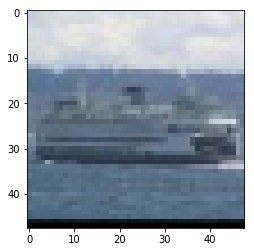

In [7]:
train_dataset = DenoisingDataset('data', 
                                 transform=transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print(next(iter(train_loader))[0].shape)

def show_img(image):
    print(image)
    plt.imshow(image.permute(1, 2, 0).type(torch.FloatTensor)  )
    plt.pause(0.001)  # pause a bit so that plots are updated
    
show_img(train_dataset.get_train_data(5)[0][3])
show_img(train_dataset.get_train_data(5)[1][3])

0it [00:00, ?it/s]

Epoch:  0 | train loss: 0.0797
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


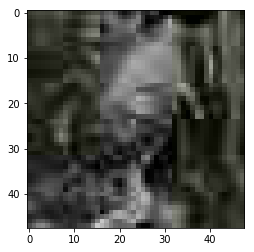

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

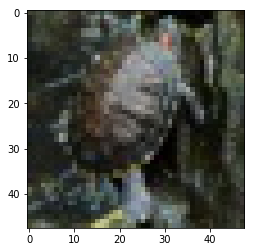

tensor([[[0.5929, 0.5760, 0.5843,  ..., 0.5849, 0.5625, 0.5626],
         [0.5639, 0.5551, 0.5659,  ..., 0.5729, 0.5443, 0.5499],
         [0.5628, 0.5524, 0.5703,  ..., 0.5834, 0.5599, 0.5532],
         ...,
         [0.5715, 0.5420, 0.5355,  ..., 0.5337, 0.5482, 0.5582],
         [0.5934, 0.5701, 0.5856,  ..., 0.5432, 0.5607, 0.5427],
         [0.5949, 0.6023, 0.6096,  ..., 0.5515, 0.5740, 0.5592]],

        [[0.5503, 0.5355, 0.5419,  ..., 0.5431, 0.5193, 0.5251],
         [0.5175, 0.5129, 0.5209,  ..., 0.5341, 0.5047, 0.5203],
         [0.5111, 0.5032, 0.5171,  ..., 0.5457, 0.5220, 0.5268],
         ...,
         [0.5306, 0.5067, 0.4965,  ..., 0.5061, 0.5216, 0.5398],
         [0.5558, 0.5407, 0.5534,  ..., 0.5185, 0.5385, 0.5276],
         [0.5839, 0.5947, 0.5980,  ..., 0.5430, 0.5656, 0.5494]],

        [[0.5708, 0.5591, 0.5685,  ..., 0.5592, 0.5360, 0.5306],
         [0.5514, 0.5508, 0.5594,  ..., 0.5593, 0.5309, 0.5339],
         [0.5501, 0.5469, 0.5599,  ..., 0.5684, 0.5449, 0.

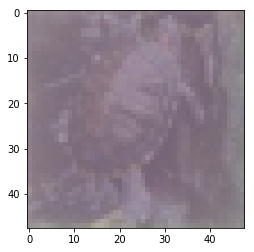

100it [00:26,  3.87it/s]

Epoch:  0 | train loss: 0.0133
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


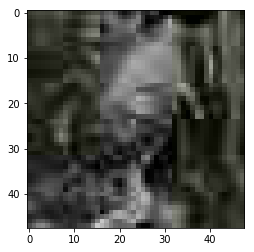

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

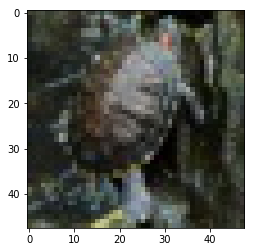

tensor([[[0.4512, 0.2927, 0.2730,  ..., 0.2803, 0.2944, 0.3637],
         [0.3570, 0.1740, 0.1544,  ..., 0.1844, 0.2022, 0.2761],
         [0.3425, 0.1493, 0.1378,  ..., 0.2108, 0.2305, 0.2872],
         ...,
         [0.3259, 0.1136, 0.0941,  ..., 0.0823, 0.1109, 0.1767],
         [0.3549, 0.1349, 0.1197,  ..., 0.0922, 0.1249, 0.1760],
         [0.4306, 0.2561, 0.2318,  ..., 0.1796, 0.2250, 0.2734]],

        [[0.3733, 0.2646, 0.2369,  ..., 0.2186, 0.2346, 0.3394],
         [0.3100, 0.2131, 0.1886,  ..., 0.2121, 0.2265, 0.3317],
         [0.2765, 0.1766, 0.1581,  ..., 0.2213, 0.2390, 0.3372],
         ...,
         [0.2705, 0.1548, 0.1205,  ..., 0.0977, 0.1302, 0.2583],
         [0.2979, 0.1801, 0.1523,  ..., 0.1133, 0.1523, 0.2637],
         [0.4035, 0.3081, 0.2677,  ..., 0.1994, 0.2428, 0.3239]],

        [[0.3335, 0.2480, 0.2217,  ..., 0.2270, 0.2550, 0.3320],
         [0.2528, 0.1770, 0.1491,  ..., 0.1739, 0.2026, 0.2751],
         [0.2235, 0.1419, 0.1188,  ..., 0.1678, 0.1994, 0.

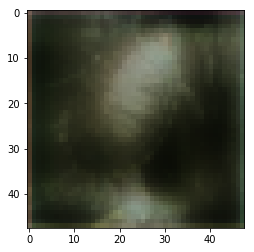

200it [00:53,  3.80it/s]

Epoch:  0 | train loss: 0.0124
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


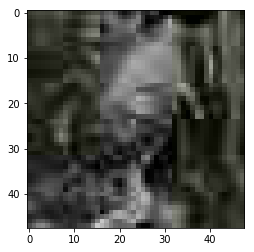

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

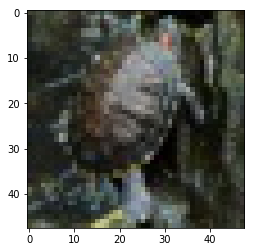

tensor([[[0.3926, 0.2987, 0.3222,  ..., 0.2888, 0.2849, 0.3497],
         [0.3065, 0.2005, 0.2324,  ..., 0.2514, 0.2442, 0.3022],
         [0.3023, 0.1924, 0.2346,  ..., 0.3378, 0.3206, 0.3464],
         ...,
         [0.3325, 0.2075, 0.2098,  ..., 0.1497, 0.1488, 0.1914],
         [0.3454, 0.2089, 0.2101,  ..., 0.1218, 0.1326, 0.1690],
         [0.4118, 0.3022, 0.2863,  ..., 0.1682, 0.1931, 0.2378]],

        [[0.3425, 0.2667, 0.2823,  ..., 0.2475, 0.2443, 0.3073],
         [0.2829, 0.2312, 0.2408,  ..., 0.2697, 0.2572, 0.3076],
         [0.2660, 0.2168, 0.2263,  ..., 0.3323, 0.3155, 0.3520],
         ...,
         [0.3145, 0.2513, 0.2201,  ..., 0.1590, 0.1626, 0.2100],
         [0.3365, 0.2643, 0.2360,  ..., 0.1386, 0.1530, 0.1923],
         [0.4137, 0.3501, 0.3050,  ..., 0.1794, 0.2023, 0.2473]],

        [[0.3058, 0.2625, 0.2756,  ..., 0.2295, 0.2375, 0.3032],
         [0.2430, 0.2026, 0.2204,  ..., 0.2163, 0.2190, 0.2675],
         [0.2270, 0.1885, 0.2104,  ..., 0.2708, 0.2672, 0.

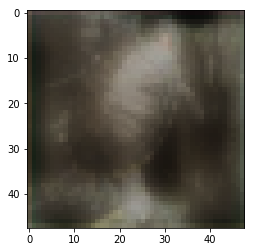

300it [01:19,  3.86it/s]

Epoch:  0 | train loss: 0.0086
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


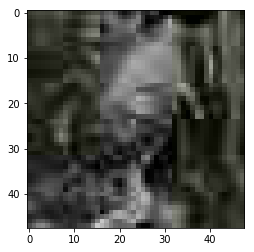

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

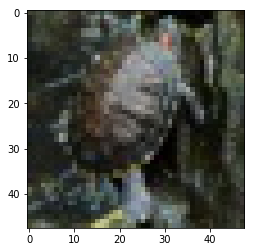

tensor([[[0.3563, 0.2769, 0.3069,  ..., 0.2657, 0.2597, 0.3196],
         [0.2843, 0.2061, 0.2459,  ..., 0.2514, 0.2476, 0.3007],
         [0.2783, 0.2012, 0.2527,  ..., 0.3250, 0.3165, 0.3457],
         ...,
         [0.3261, 0.2259, 0.2286,  ..., 0.1595, 0.1566, 0.1814],
         [0.3446, 0.2410, 0.2524,  ..., 0.1427, 0.1518, 0.1695],
         [0.4159, 0.3385, 0.3390,  ..., 0.2010, 0.2265, 0.2512]],

        [[0.3305, 0.2612, 0.2875,  ..., 0.2429, 0.2364, 0.2869],
         [0.2681, 0.2405, 0.2613,  ..., 0.2672, 0.2549, 0.2967],
         [0.2521, 0.2304, 0.2557,  ..., 0.3278, 0.3143, 0.3473],
         ...,
         [0.3176, 0.2689, 0.2403,  ..., 0.1626, 0.1576, 0.1864],
         [0.3438, 0.2919, 0.2781,  ..., 0.1546, 0.1605, 0.1834],
         [0.4194, 0.3829, 0.3614,  ..., 0.2130, 0.2286, 0.2582]],

        [[0.2658, 0.2283, 0.2612,  ..., 0.2244, 0.2239, 0.2843],
         [0.2202, 0.1908, 0.2263,  ..., 0.2265, 0.2219, 0.2633],
         [0.2085, 0.1853, 0.2289,  ..., 0.2872, 0.2787, 0.

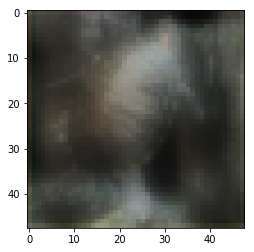

313it [01:23,  4.52it/s]
0it [00:00, ?it/s]

Epoch:  1 | train loss: 0.0084
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


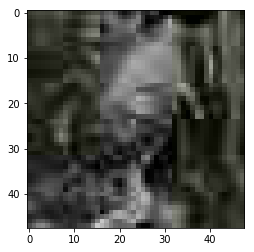

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

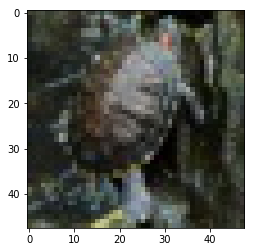

tensor([[[0.3228, 0.2339, 0.2543,  ..., 0.2246, 0.2191, 0.2832],
         [0.2460, 0.1630, 0.1920,  ..., 0.2095, 0.2016, 0.2530],
         [0.2339, 0.1533, 0.1937,  ..., 0.2794, 0.2613, 0.2887],
         ...,
         [0.2701, 0.1651, 0.1650,  ..., 0.1035, 0.1014, 0.1271],
         [0.2841, 0.1697, 0.1704,  ..., 0.0889, 0.0980, 0.1205],
         [0.3675, 0.2667, 0.2547,  ..., 0.1424, 0.1675, 0.2004]],

        [[0.3020, 0.2221, 0.2412,  ..., 0.2111, 0.2059, 0.2562],
         [0.2340, 0.1951, 0.2152,  ..., 0.2375, 0.2220, 0.2562],
         [0.2154, 0.1830, 0.2109,  ..., 0.3011, 0.2773, 0.2970],
         ...,
         [0.2768, 0.2187, 0.1985,  ..., 0.1226, 0.1156, 0.1377],
         [0.2981, 0.2293, 0.2149,  ..., 0.1101, 0.1156, 0.1366],
         [0.3808, 0.3214, 0.2925,  ..., 0.1636, 0.1802, 0.2122]],

        [[0.2419, 0.1978, 0.2200,  ..., 0.1967, 0.1948, 0.2548],
         [0.1932, 0.1586, 0.1858,  ..., 0.2004, 0.1890, 0.2232],
         [0.1808, 0.1529, 0.1889,  ..., 0.2643, 0.2419, 0.

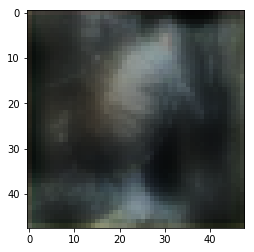

100it [00:26,  3.90it/s]

Epoch:  1 | train loss: 0.0084
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


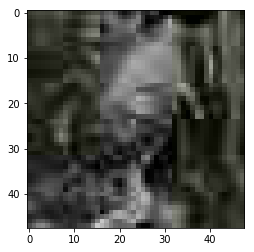

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

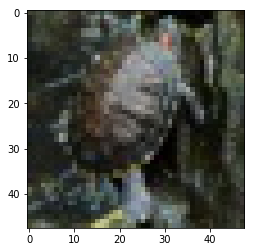

tensor([[[0.3487, 0.2796, 0.3193,  ..., 0.2541, 0.2368, 0.2884],
         [0.2818, 0.2197, 0.2606,  ..., 0.2497, 0.2313, 0.2704],
         [0.2842, 0.2231, 0.2681,  ..., 0.3229, 0.2960, 0.3101],
         ...,
         [0.3065, 0.2200, 0.2184,  ..., 0.1572, 0.1462, 0.1622],
         [0.3139, 0.2209, 0.2260,  ..., 0.1287, 0.1346, 0.1499],
         [0.3804, 0.3042, 0.2982,  ..., 0.1695, 0.1930, 0.2234]],

        [[0.3283, 0.2632, 0.2975,  ..., 0.2404, 0.2258, 0.2639],
         [0.2686, 0.2534, 0.2773,  ..., 0.2630, 0.2384, 0.2637],
         [0.2616, 0.2506, 0.2697,  ..., 0.3191, 0.2901, 0.3038],
         ...,
         [0.3115, 0.2620, 0.2341,  ..., 0.1577, 0.1453, 0.1588],
         [0.3311, 0.2735, 0.2595,  ..., 0.1407, 0.1428, 0.1559],
         [0.3982, 0.3520, 0.3287,  ..., 0.1836, 0.1975, 0.2252]],

        [[0.2670, 0.2313, 0.2657,  ..., 0.2152, 0.2060, 0.2577],
         [0.2321, 0.2080, 0.2385,  ..., 0.2181, 0.2021, 0.2310],
         [0.2252, 0.2060, 0.2382,  ..., 0.2708, 0.2476, 0.

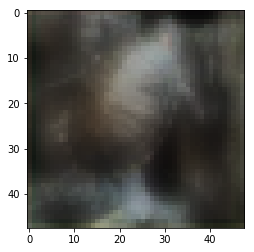

200it [00:53,  3.91it/s]

Epoch:  1 | train loss: 0.0080
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


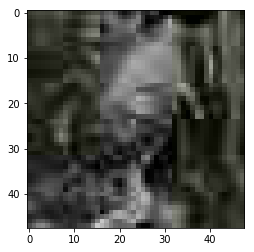

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

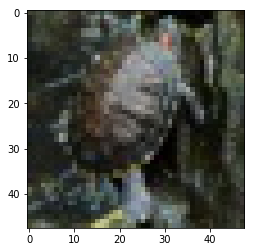

tensor([[[0.3052, 0.2385, 0.2867,  ..., 0.2743, 0.2459, 0.2871],
         [0.2385, 0.1828, 0.2238,  ..., 0.2570, 0.2376, 0.2747],
         [0.2458, 0.1922, 0.2321,  ..., 0.3139, 0.2965, 0.3185],
         ...,
         [0.2828, 0.2038, 0.2023,  ..., 0.1631, 0.1630, 0.1836],
         [0.3057, 0.2232, 0.2332,  ..., 0.1512, 0.1606, 0.1721],
         [0.3814, 0.3200, 0.3211,  ..., 0.2002, 0.2227, 0.2455]],

        [[0.3066, 0.2365, 0.2820,  ..., 0.2779, 0.2511, 0.2740],
         [0.2520, 0.2368, 0.2704,  ..., 0.2910, 0.2586, 0.2765],
         [0.2502, 0.2398, 0.2618,  ..., 0.3295, 0.3036, 0.3226],
         ...,
         [0.3034, 0.2604, 0.2365,  ..., 0.1748, 0.1717, 0.1905],
         [0.3336, 0.2892, 0.2839,  ..., 0.1757, 0.1818, 0.1904],
         [0.4086, 0.3770, 0.3637,  ..., 0.2232, 0.2345, 0.2530]],

        [[0.2401, 0.2082, 0.2487,  ..., 0.2440, 0.2236, 0.2610],
         [0.2108, 0.1929, 0.2299,  ..., 0.2422, 0.2228, 0.2394],
         [0.2089, 0.1954, 0.2304,  ..., 0.2795, 0.2612, 0.

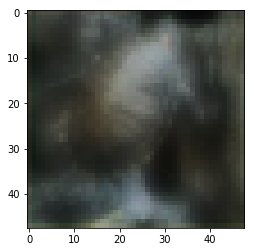

300it [01:19,  3.92it/s]

Epoch:  1 | train loss: 0.0076
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


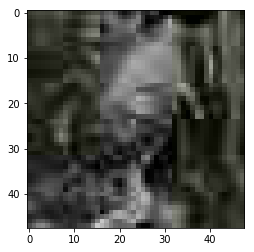

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

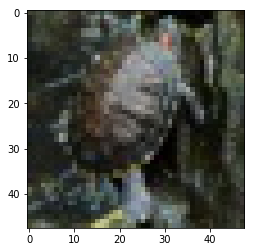

tensor([[[0.3031, 0.2413, 0.2913,  ..., 0.2989, 0.2622, 0.2918],
         [0.2366, 0.1904, 0.2326,  ..., 0.2746, 0.2475, 0.2763],
         [0.2443, 0.2032, 0.2435,  ..., 0.3197, 0.2975, 0.3135],
         ...,
         [0.2809, 0.2069, 0.2021,  ..., 0.1643, 0.1627, 0.1731],
         [0.3018, 0.2215, 0.2261,  ..., 0.1490, 0.1600, 0.1650],
         [0.3721, 0.3083, 0.3026,  ..., 0.1888, 0.2131, 0.2343]],

        [[0.2991, 0.2306, 0.2786,  ..., 0.3046, 0.2723, 0.2808],
         [0.2396, 0.2263, 0.2649,  ..., 0.3059, 0.2679, 0.2754],
         [0.2353, 0.2281, 0.2556,  ..., 0.3308, 0.3014, 0.3135],
         ...,
         [0.2918, 0.2443, 0.2194,  ..., 0.1607, 0.1566, 0.1680],
         [0.3193, 0.2670, 0.2570,  ..., 0.1576, 0.1648, 0.1709],
         [0.3941, 0.3495, 0.3300,  ..., 0.1979, 0.2117, 0.2322]],

        [[0.2359, 0.2045, 0.2434,  ..., 0.2717, 0.2445, 0.2696],
         [0.2040, 0.1904, 0.2263,  ..., 0.2652, 0.2407, 0.2442],
         [0.2037, 0.1964, 0.2318,  ..., 0.2929, 0.2716, 0.

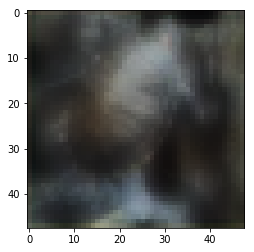

313it [01:22,  4.62it/s]
0it [00:00, ?it/s]

Epoch:  2 | train loss: 0.0074
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


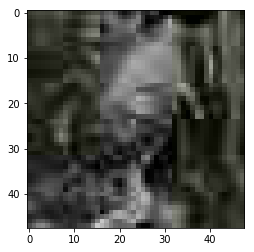

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

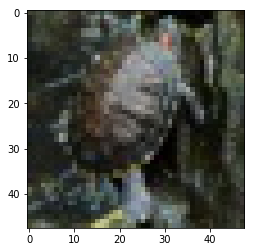

tensor([[[0.3026, 0.2401, 0.2879,  ..., 0.3118, 0.2733, 0.3007],
         [0.2308, 0.1851, 0.2259,  ..., 0.2806, 0.2541, 0.2840],
         [0.2349, 0.1943, 0.2340,  ..., 0.3189, 0.3002, 0.3195],
         ...,
         [0.2717, 0.1996, 0.1966,  ..., 0.1660, 0.1690, 0.1837],
         [0.2984, 0.2215, 0.2291,  ..., 0.1540, 0.1675, 0.1748],
         [0.3727, 0.3132, 0.3106,  ..., 0.1947, 0.2200, 0.2428]],

        [[0.3022, 0.2334, 0.2796,  ..., 0.3184, 0.2853, 0.2914],
         [0.2424, 0.2294, 0.2661,  ..., 0.3163, 0.2785, 0.2873],
         [0.2348, 0.2277, 0.2544,  ..., 0.3335, 0.3069, 0.3233],
         ...,
         [0.2872, 0.2422, 0.2186,  ..., 0.1677, 0.1678, 0.1822],
         [0.3196, 0.2729, 0.2656,  ..., 0.1686, 0.1785, 0.1853],
         [0.3997, 0.3612, 0.3447,  ..., 0.2099, 0.2243, 0.2444]],

        [[0.2352, 0.2037, 0.2415,  ..., 0.2767, 0.2492, 0.2739],
         [0.2005, 0.1879, 0.2229,  ..., 0.2645, 0.2417, 0.2480],
         [0.1977, 0.1906, 0.2256,  ..., 0.2855, 0.2678, 0.

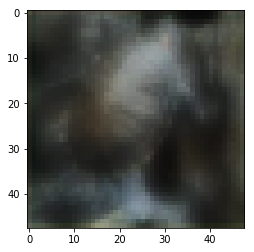

100it [00:26,  3.86it/s]

Epoch:  2 | train loss: 0.0064
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


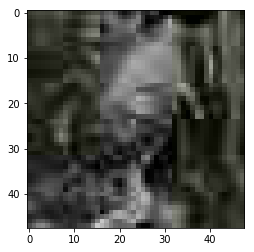

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

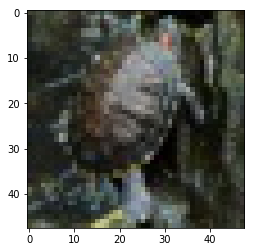

tensor([[[0.2943, 0.2325, 0.2805,  ..., 0.3145, 0.2622, 0.2827],
         [0.2254, 0.1852, 0.2262,  ..., 0.2859, 0.2474, 0.2714],
         [0.2316, 0.1990, 0.2397,  ..., 0.3200, 0.2928, 0.3092],
         ...,
         [0.2743, 0.2104, 0.2081,  ..., 0.1819, 0.1847, 0.1977],
         [0.3066, 0.2388, 0.2487,  ..., 0.1756, 0.1887, 0.1914],
         [0.3818, 0.3336, 0.3329,  ..., 0.2178, 0.2423, 0.2607]],

        [[0.2928, 0.2247, 0.2720,  ..., 0.3274, 0.2809, 0.2766],
         [0.2312, 0.2197, 0.2606,  ..., 0.3243, 0.2747, 0.2723],
         [0.2257, 0.2212, 0.2534,  ..., 0.3383, 0.3036, 0.3111],
         ...,
         [0.2856, 0.2448, 0.2217,  ..., 0.1738, 0.1766, 0.1910],
         [0.3212, 0.2814, 0.2755,  ..., 0.1830, 0.1950, 0.1989],
         [0.4066, 0.3750, 0.3602,  ..., 0.2296, 0.2437, 0.2591]],

        [[0.2275, 0.1945, 0.2306,  ..., 0.2809, 0.2430, 0.2591],
         [0.1919, 0.1806, 0.2146,  ..., 0.2708, 0.2395, 0.2349],
         [0.1905, 0.1865, 0.2215,  ..., 0.2896, 0.2667, 0.

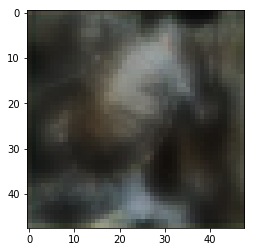

200it [00:53,  3.85it/s]

Epoch:  2 | train loss: 0.0079
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


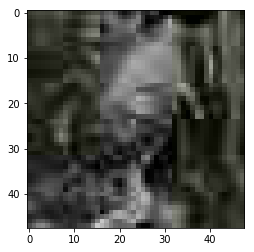

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

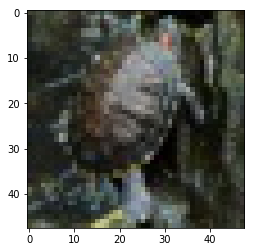

tensor([[[0.2879, 0.2264, 0.2734,  ..., 0.3244, 0.2663, 0.2793],
         [0.2197, 0.1807, 0.2215,  ..., 0.3021, 0.2538, 0.2660],
         [0.2250, 0.1922, 0.2309,  ..., 0.3341, 0.2983, 0.3027],
         ...,
         [0.2744, 0.2131, 0.2096,  ..., 0.1981, 0.1974, 0.2045],
         [0.3124, 0.2487, 0.2582,  ..., 0.1983, 0.2067, 0.2012],
         [0.3871, 0.3454, 0.3444,  ..., 0.2369, 0.2549, 0.2674]],

        [[0.2870, 0.2171, 0.2640,  ..., 0.3327, 0.2832, 0.2735],
         [0.2224, 0.2044, 0.2458,  ..., 0.3315, 0.2772, 0.2653],
         [0.2187, 0.2082, 0.2419,  ..., 0.3466, 0.3064, 0.3015],
         ...,
         [0.2886, 0.2485, 0.2256,  ..., 0.1905, 0.1911, 0.1965],
         [0.3275, 0.2918, 0.2858,  ..., 0.2069, 0.2169, 0.2091],
         [0.4143, 0.3856, 0.3703,  ..., 0.2521, 0.2617, 0.2677]],

        [[0.2261, 0.1919, 0.2246,  ..., 0.2792, 0.2395, 0.2531],
         [0.1870, 0.1740, 0.2038,  ..., 0.2676, 0.2319, 0.2258],
         [0.1876, 0.1815, 0.2119,  ..., 0.2864, 0.2587, 0.

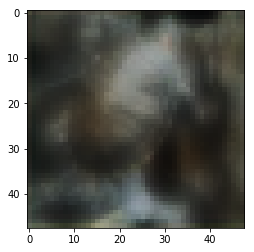

300it [01:19,  3.82it/s]

Epoch:  2 | train loss: 0.0063
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


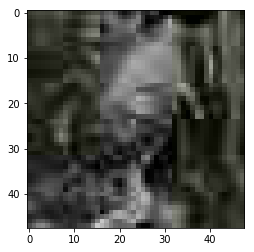

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

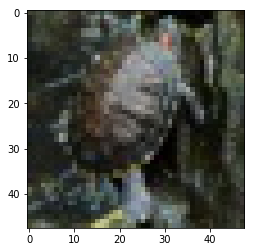

tensor([[[0.2756, 0.2117, 0.2555,  ..., 0.2921, 0.2361, 0.2522],
         [0.2113, 0.1706, 0.2073,  ..., 0.2839, 0.2309, 0.2385],
         [0.2164, 0.1827, 0.2186,  ..., 0.3311, 0.2823, 0.2775],
         ...,
         [0.2657, 0.2038, 0.1979,  ..., 0.1819, 0.1815, 0.1873],
         [0.3074, 0.2433, 0.2500,  ..., 0.1694, 0.1830, 0.1833],
         [0.3845, 0.3431, 0.3398,  ..., 0.1979, 0.2233, 0.2475]],

        [[0.2782, 0.2087, 0.2544,  ..., 0.3089, 0.2593, 0.2499],
         [0.2156, 0.1966, 0.2380,  ..., 0.3248, 0.2653, 0.2409],
         [0.2159, 0.2056, 0.2411,  ..., 0.3599, 0.3079, 0.2807],
         ...,
         [0.2834, 0.2418, 0.2188,  ..., 0.1850, 0.1856, 0.1827],
         [0.3250, 0.2886, 0.2828,  ..., 0.1876, 0.2010, 0.1923],
         [0.4151, 0.3873, 0.3725,  ..., 0.2206, 0.2372, 0.2494]],

        [[0.2215, 0.1841, 0.2146,  ..., 0.2594, 0.2201, 0.2306],
         [0.1809, 0.1645, 0.1928,  ..., 0.2609, 0.2205, 0.2036],
         [0.1872, 0.1799, 0.2105,  ..., 0.3010, 0.2629, 0.

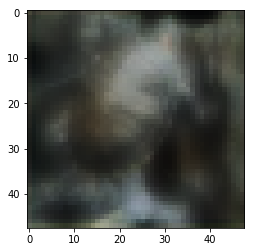

313it [01:23,  4.53it/s]
0it [00:00, ?it/s]

Epoch:  3 | train loss: 0.0080
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


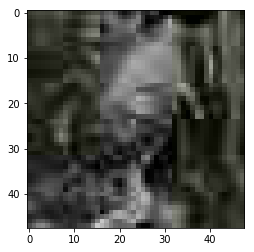

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

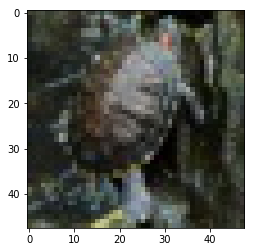

tensor([[[0.2919, 0.2307, 0.2723,  ..., 0.3370, 0.2671, 0.2728],
         [0.2232, 0.1870, 0.2251,  ..., 0.3210, 0.2573, 0.2596],
         [0.2246, 0.1951, 0.2331,  ..., 0.3506, 0.2992, 0.2943],
         ...,
         [0.2815, 0.2239, 0.2177,  ..., 0.2051, 0.2049, 0.2097],
         [0.3237, 0.2657, 0.2743,  ..., 0.1939, 0.2068, 0.2025],
         [0.3973, 0.3642, 0.3636,  ..., 0.2210, 0.2458, 0.2650]],

        [[0.2854, 0.2170, 0.2597,  ..., 0.3486, 0.2882, 0.2691],
         [0.2188, 0.2005, 0.2402,  ..., 0.3564, 0.2881, 0.2611],
         [0.2136, 0.2032, 0.2389,  ..., 0.3737, 0.3201, 0.2964],
         ...,
         [0.2880, 0.2486, 0.2250,  ..., 0.1951, 0.1986, 0.2007],
         [0.3309, 0.2992, 0.2935,  ..., 0.2012, 0.2174, 0.2091],
         [0.4200, 0.3978, 0.3847,  ..., 0.2360, 0.2534, 0.2645]],

        [[0.2247, 0.1887, 0.2182,  ..., 0.2955, 0.2453, 0.2472],
         [0.1804, 0.1668, 0.1946,  ..., 0.2926, 0.2437, 0.2205],
         [0.1826, 0.1761, 0.2060,  ..., 0.3172, 0.2774, 0.

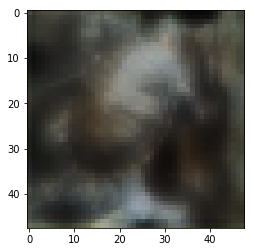

100it [00:26,  3.97it/s]

Epoch:  3 | train loss: 0.0061
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


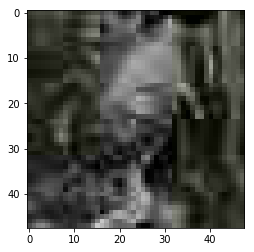

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

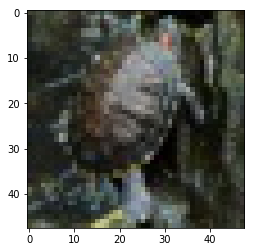

tensor([[[0.2766, 0.2142, 0.2531,  ..., 0.3003, 0.2279, 0.2321],
         [0.2055, 0.1691, 0.2055,  ..., 0.2908, 0.2224, 0.2184],
         [0.2047, 0.1738, 0.2089,  ..., 0.3276, 0.2682, 0.2560],
         ...,
         [0.2645, 0.2052, 0.1994,  ..., 0.1921, 0.1930, 0.2000],
         [0.3106, 0.2509, 0.2585,  ..., 0.1906, 0.2023, 0.1971],
         [0.3909, 0.3572, 0.3559,  ..., 0.2237, 0.2454, 0.2620]],

        [[0.2852, 0.2160, 0.2585,  ..., 0.3225, 0.2577, 0.2343],
         [0.2163, 0.1953, 0.2370,  ..., 0.3391, 0.2627, 0.2220],
         [0.2120, 0.1978, 0.2352,  ..., 0.3656, 0.3020, 0.2608],
         ...,
         [0.2893, 0.2487, 0.2264,  ..., 0.1943, 0.1983, 0.1976],
         [0.3324, 0.3019, 0.2969,  ..., 0.2071, 0.2229, 0.2095],
         [0.4192, 0.3983, 0.3854,  ..., 0.2426, 0.2562, 0.2632]],

        [[0.2190, 0.1865, 0.2149,  ..., 0.2626, 0.2118, 0.2132],
         [0.1706, 0.1625, 0.1908,  ..., 0.2610, 0.2099, 0.1834],
         [0.1734, 0.1718, 0.2011,  ..., 0.2939, 0.2490, 0.

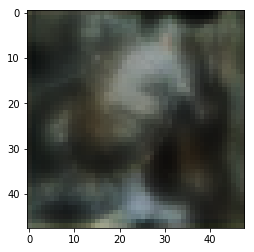

200it [00:52,  3.72it/s]

Epoch:  3 | train loss: 0.0065
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


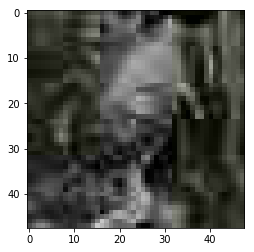

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

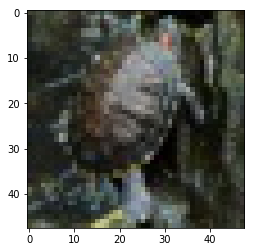

tensor([[[0.2708, 0.2145, 0.2523,  ..., 0.2931, 0.2255, 0.2354],
         [0.2005, 0.1708, 0.2088,  ..., 0.2885, 0.2290, 0.2344],
         [0.1972, 0.1724, 0.2110,  ..., 0.3267, 0.2799, 0.2811],
         ...,
         [0.2633, 0.2080, 0.2015,  ..., 0.1932, 0.2067, 0.2324],
         [0.3141, 0.2596, 0.2668,  ..., 0.1960, 0.2188, 0.2258],
         [0.3946, 0.3668, 0.3656,  ..., 0.2312, 0.2616, 0.2866]],

        [[0.2687, 0.2100, 0.2523,  ..., 0.3133, 0.2507, 0.2369],
         [0.2008, 0.1900, 0.2346,  ..., 0.3401, 0.2703, 0.2414],
         [0.1949, 0.1894, 0.2339,  ..., 0.3724, 0.3192, 0.2918],
         ...,
         [0.2776, 0.2410, 0.2202,  ..., 0.1923, 0.2108, 0.2349],
         [0.3260, 0.2993, 0.2950,  ..., 0.2099, 0.2393, 0.2445],
         [0.4197, 0.4017, 0.3895,  ..., 0.2507, 0.2740, 0.2937]],

        [[0.2133, 0.1868, 0.2146,  ..., 0.2569, 0.2092, 0.2184],
         [0.1607, 0.1571, 0.1884,  ..., 0.2619, 0.2179, 0.2013],
         [0.1612, 0.1628, 0.1963,  ..., 0.3028, 0.2682, 0.

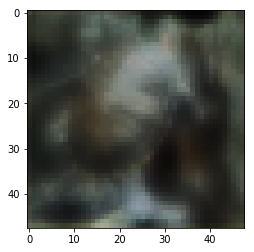

300it [01:17,  3.97it/s]

Epoch:  3 | train loss: 0.0070
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


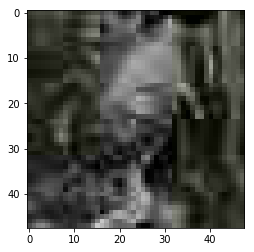

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

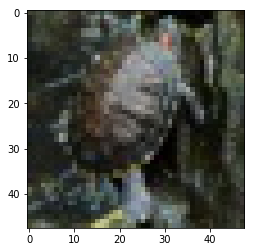

tensor([[[0.2840, 0.2306, 0.2637,  ..., 0.3055, 0.2371, 0.2431],
         [0.2106, 0.1851, 0.2204,  ..., 0.3118, 0.2511, 0.2470],
         [0.2037, 0.1823, 0.2200,  ..., 0.3501, 0.3015, 0.2911],
         ...,
         [0.2658, 0.2136, 0.2048,  ..., 0.1990, 0.2122, 0.2288],
         [0.3127, 0.2613, 0.2664,  ..., 0.1955, 0.2180, 0.2189],
         [0.3861, 0.3585, 0.3545,  ..., 0.2218, 0.2538, 0.2775]],

        [[0.2866, 0.2329, 0.2712,  ..., 0.3176, 0.2528, 0.2401],
         [0.2158, 0.2096, 0.2514,  ..., 0.3539, 0.2785, 0.2468],
         [0.2073, 0.2050, 0.2486,  ..., 0.3883, 0.3294, 0.2958],
         ...,
         [0.2775, 0.2426, 0.2207,  ..., 0.1984, 0.2109, 0.2261],
         [0.3205, 0.2936, 0.2885,  ..., 0.2099, 0.2335, 0.2326],
         [0.4126, 0.3896, 0.3761,  ..., 0.2383, 0.2562, 0.2741]],

        [[0.2254, 0.1999, 0.2245,  ..., 0.2565, 0.2081, 0.2170],
         [0.1669, 0.1659, 0.1940,  ..., 0.2664, 0.2195, 0.2017],
         [0.1640, 0.1667, 0.1975,  ..., 0.3092, 0.2696, 0.

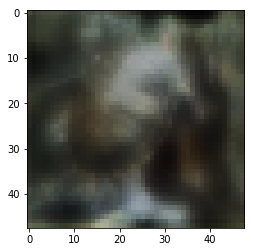

313it [01:21,  4.62it/s]
0it [00:00, ?it/s]

Epoch:  4 | train loss: 0.0065
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


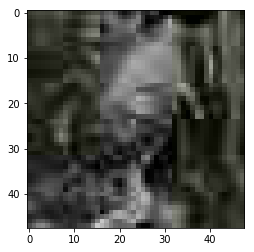

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

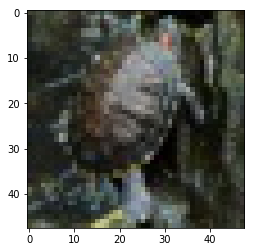

tensor([[[0.2366, 0.1796, 0.2232,  ..., 0.2450, 0.1916, 0.2090],
         [0.1881, 0.1592, 0.1975,  ..., 0.2735, 0.2162, 0.2089],
         [0.1932, 0.1704, 0.2063,  ..., 0.3334, 0.2758, 0.2503],
         ...,
         [0.2557, 0.2022, 0.1954,  ..., 0.1934, 0.2000, 0.2044],
         [0.3024, 0.2490, 0.2550,  ..., 0.1887, 0.2071, 0.2014],
         [0.3776, 0.3464, 0.3426,  ..., 0.2142, 0.2447, 0.2656]],

        [[0.2351, 0.1762, 0.2205,  ..., 0.2473, 0.1960, 0.2004],
         [0.1799, 0.1714, 0.2170,  ..., 0.2989, 0.2289, 0.2015],
         [0.1887, 0.1859, 0.2283,  ..., 0.3573, 0.2894, 0.2474],
         ...,
         [0.2693, 0.2340, 0.2147,  ..., 0.1893, 0.1934, 0.1958],
         [0.3122, 0.2844, 0.2806,  ..., 0.2009, 0.2178, 0.2091],
         [0.4068, 0.3817, 0.3686,  ..., 0.2316, 0.2464, 0.2596]],

        [[0.1885, 0.1602, 0.1879,  ..., 0.1939, 0.1583, 0.1780],
         [0.1482, 0.1405, 0.1689,  ..., 0.2105, 0.1683, 0.1574],
         [0.1580, 0.1571, 0.1858,  ..., 0.2656, 0.2191, 0.

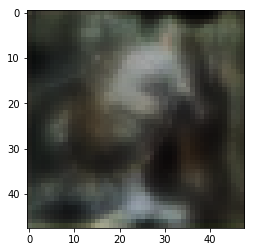

100it [00:25,  3.85it/s]

Epoch:  4 | train loss: 0.0062
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


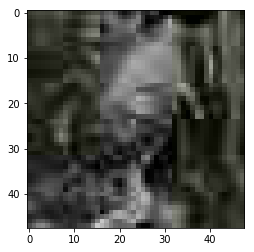

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

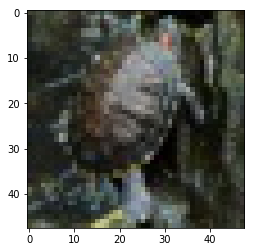

tensor([[[0.2699, 0.2192, 0.2546,  ..., 0.2917, 0.2233, 0.2289],
         [0.2000, 0.1769, 0.2134,  ..., 0.3025, 0.2420, 0.2338],
         [0.1938, 0.1730, 0.2100,  ..., 0.3400, 0.2927, 0.2788],
         ...,
         [0.2617, 0.2087, 0.1982,  ..., 0.1965, 0.2093, 0.2221],
         [0.3111, 0.2593, 0.2629,  ..., 0.1944, 0.2177, 0.2157],
         [0.3884, 0.3610, 0.3572,  ..., 0.2227, 0.2553, 0.2765]],

        [[0.2678, 0.2138, 0.2542,  ..., 0.2951, 0.2313, 0.2212],
         [0.1997, 0.1933, 0.2357,  ..., 0.3372, 0.2624, 0.2297],
         [0.1928, 0.1900, 0.2334,  ..., 0.3715, 0.3140, 0.2805],
         ...,
         [0.2726, 0.2388, 0.2155,  ..., 0.1905, 0.2026, 0.2158],
         [0.3192, 0.2948, 0.2877,  ..., 0.2038, 0.2276, 0.2257],
         [0.4128, 0.3933, 0.3795,  ..., 0.2368, 0.2551, 0.2718]],

        [[0.2136, 0.1906, 0.2159,  ..., 0.2339, 0.1876, 0.1991],
         [0.1599, 0.1604, 0.1881,  ..., 0.2455, 0.2011, 0.1845],
         [0.1583, 0.1622, 0.1912,  ..., 0.2855, 0.2490, 0.

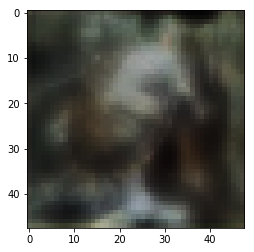

200it [00:52,  3.94it/s]

Epoch:  4 | train loss: 0.0059
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


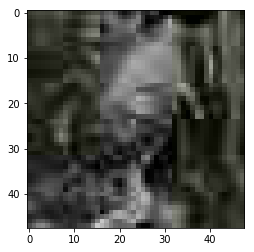

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

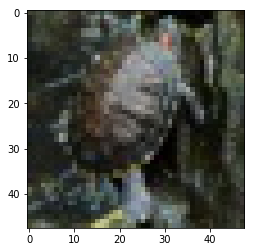

tensor([[[0.2670, 0.2167, 0.2519,  ..., 0.2879, 0.2199, 0.2260],
         [0.1964, 0.1735, 0.2101,  ..., 0.3000, 0.2403, 0.2328],
         [0.1904, 0.1694, 0.2064,  ..., 0.3381, 0.2919, 0.2794],
         ...,
         [0.2599, 0.2081, 0.1979,  ..., 0.1961, 0.2099, 0.2248],
         [0.3096, 0.2595, 0.2640,  ..., 0.1973, 0.2210, 0.2197],
         [0.3872, 0.3618, 0.3593,  ..., 0.2270, 0.2595, 0.2809]],

        [[0.2685, 0.2151, 0.2562,  ..., 0.2942, 0.2302, 0.2198],
         [0.2001, 0.1939, 0.2364,  ..., 0.3380, 0.2637, 0.2310],
         [0.1935, 0.1906, 0.2341,  ..., 0.3730, 0.3166, 0.2831],
         ...,
         [0.2737, 0.2423, 0.2193,  ..., 0.1956, 0.2079, 0.2211],
         [0.3208, 0.2993, 0.2932,  ..., 0.2119, 0.2354, 0.2322],
         [0.4134, 0.3960, 0.3833,  ..., 0.2448, 0.2626, 0.2783]],

        [[0.2100, 0.1877, 0.2135,  ..., 0.2302, 0.1845, 0.1969],
         [0.1557, 0.1561, 0.1837,  ..., 0.2415, 0.1989, 0.1838],
         [0.1537, 0.1573, 0.1862,  ..., 0.2816, 0.2470, 0.

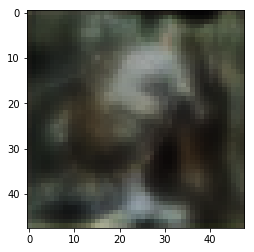

300it [01:17,  3.84it/s]

Epoch:  4 | train loss: 0.0064
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


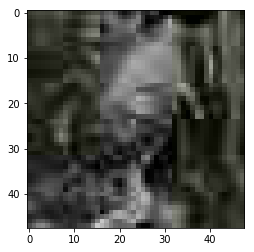

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

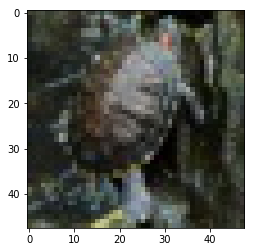

tensor([[[0.2652, 0.2151, 0.2514,  ..., 0.2843, 0.2163, 0.2234],
         [0.1967, 0.1742, 0.2120,  ..., 0.3005, 0.2403, 0.2324],
         [0.1918, 0.1712, 0.2095,  ..., 0.3417, 0.2944, 0.2807],
         ...,
         [0.2629, 0.2135, 0.2048,  ..., 0.1986, 0.2128, 0.2279],
         [0.3106, 0.2623, 0.2683,  ..., 0.1978, 0.2218, 0.2210],
         [0.3859, 0.3609, 0.3591,  ..., 0.2245, 0.2573, 0.2797]],

        [[0.2668, 0.2142, 0.2563,  ..., 0.2907, 0.2258, 0.2169],
         [0.2004, 0.1955, 0.2390,  ..., 0.3396, 0.2639, 0.2311],
         [0.1953, 0.1937, 0.2382,  ..., 0.3773, 0.3194, 0.2851],
         ...,
         [0.2769, 0.2494, 0.2275,  ..., 0.1989, 0.2108, 0.2244],
         [0.3225, 0.3043, 0.2998,  ..., 0.2134, 0.2367, 0.2339],
         [0.4130, 0.3965, 0.3845,  ..., 0.2432, 0.2606, 0.2773]],

        [[0.2099, 0.1883, 0.2147,  ..., 0.2276, 0.1815, 0.1945],
         [0.1579, 0.1590, 0.1875,  ..., 0.2426, 0.1992, 0.1833],
         [0.1570, 0.1616, 0.1913,  ..., 0.2857, 0.2498, 0.

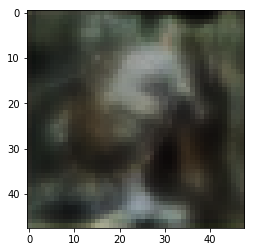

313it [01:21,  4.42it/s]
0it [00:00, ?it/s]

Epoch:  5 | train loss: 0.0067
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


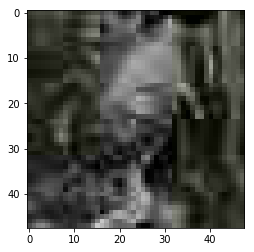

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

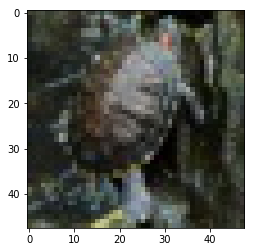

tensor([[[0.2602, 0.2100, 0.2478,  ..., 0.2830, 0.2163, 0.2249],
         [0.1943, 0.1721, 0.2105,  ..., 0.3003, 0.2417, 0.2353],
         [0.1904, 0.1704, 0.2086,  ..., 0.3417, 0.2966, 0.2848],
         ...,
         [0.2617, 0.2133, 0.2057,  ..., 0.2010, 0.2169, 0.2334],
         [0.3091, 0.2618, 0.2687,  ..., 0.2008, 0.2260, 0.2256],
         [0.3846, 0.3602, 0.3588,  ..., 0.2275, 0.2608, 0.2833]],

        [[0.2595, 0.2069, 0.2496,  ..., 0.2866, 0.2233, 0.2168],
         [0.1946, 0.1902, 0.2346,  ..., 0.3374, 0.2631, 0.2327],
         [0.1908, 0.1898, 0.2343,  ..., 0.3751, 0.3193, 0.2882],
         ...,
         [0.2727, 0.2456, 0.2248,  ..., 0.1979, 0.2121, 0.2289],
         [0.3182, 0.3001, 0.2964,  ..., 0.2131, 0.2383, 0.2378],
         [0.4104, 0.3935, 0.3819,  ..., 0.2440, 0.2625, 0.2804]],

        [[0.2052, 0.1835, 0.2103,  ..., 0.2257, 0.1808, 0.1953],
         [0.1549, 0.1556, 0.1843,  ..., 0.2420, 0.2000, 0.1856],
         [0.1548, 0.1590, 0.1883,  ..., 0.2851, 0.2514, 0.

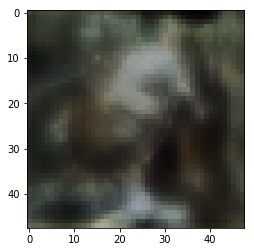

100it [00:26,  3.93it/s]

Epoch:  5 | train loss: 0.0062
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


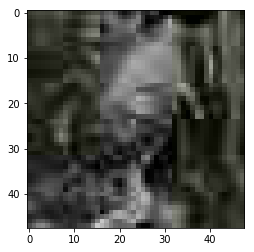

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

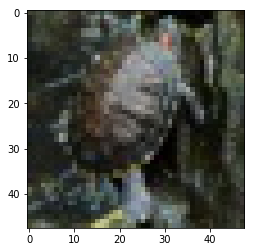

tensor([[[0.2631, 0.2137, 0.2509,  ..., 0.2785, 0.2113, 0.2201],
         [0.1966, 0.1751, 0.2141,  ..., 0.2970, 0.2376, 0.2307],
         [0.1922, 0.1719, 0.2105,  ..., 0.3383, 0.2919, 0.2795],
         ...,
         [0.2650, 0.2166, 0.2075,  ..., 0.1987, 0.2133, 0.2291],
         [0.3126, 0.2657, 0.2719,  ..., 0.1989, 0.2229, 0.2220],
         [0.3874, 0.3642, 0.3631,  ..., 0.2260, 0.2584, 0.2806]],

        [[0.2632, 0.2104, 0.2527,  ..., 0.2816, 0.2177, 0.2122],
         [0.1976, 0.1922, 0.2360,  ..., 0.3326, 0.2579, 0.2284],
         [0.1935, 0.1907, 0.2345,  ..., 0.3705, 0.3139, 0.2832],
         ...,
         [0.2771, 0.2506, 0.2282,  ..., 0.1980, 0.2103, 0.2252],
         [0.3233, 0.3063, 0.3016,  ..., 0.2139, 0.2369, 0.2345],
         [0.4134, 0.3979, 0.3860,  ..., 0.2440, 0.2608, 0.2779]],

        [[0.2083, 0.1883, 0.2156,  ..., 0.2234, 0.1782, 0.1926],
         [0.1584, 0.1611, 0.1906,  ..., 0.2409, 0.1983, 0.1833],
         [0.1581, 0.1639, 0.1937,  ..., 0.2841, 0.2495, 0.

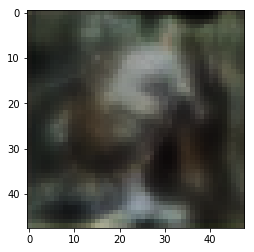

200it [00:52,  3.97it/s]

Epoch:  5 | train loss: 0.0063
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


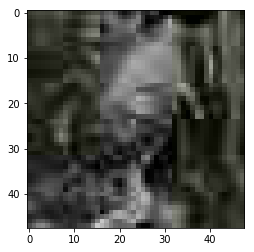

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

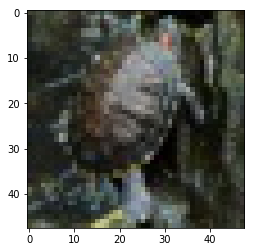

tensor([[[0.2567, 0.2073, 0.2467,  ..., 0.2751, 0.2089, 0.2185],
         [0.1928, 0.1704, 0.2095,  ..., 0.2945, 0.2374, 0.2307],
         [0.1897, 0.1683, 0.2061,  ..., 0.3371, 0.2927, 0.2806],
         ...,
         [0.2586, 0.2080, 0.1972,  ..., 0.1948, 0.2097, 0.2254],
         [0.3073, 0.2585, 0.2628,  ..., 0.1902, 0.2149, 0.2161],
         [0.3829, 0.3572, 0.3544,  ..., 0.2125, 0.2462, 0.2725]],

        [[0.2589, 0.2075, 0.2520,  ..., 0.2800, 0.2157, 0.2111],
         [0.1948, 0.1904, 0.2351,  ..., 0.3341, 0.2599, 0.2301],
         [0.1928, 0.1907, 0.2342,  ..., 0.3733, 0.3176, 0.2865],
         ...,
         [0.2718, 0.2445, 0.2213,  ..., 0.1999, 0.2111, 0.2244],
         [0.3189, 0.3013, 0.2954,  ..., 0.2105, 0.2329, 0.2309],
         [0.4109, 0.3939, 0.3810,  ..., 0.2336, 0.2515, 0.2718]],

        [[0.2048, 0.1852, 0.2135,  ..., 0.2203, 0.1756, 0.1911],
         [0.1559, 0.1571, 0.1864,  ..., 0.2379, 0.1970, 0.1831],
         [0.1567, 0.1610, 0.1900,  ..., 0.2821, 0.2490, 0.

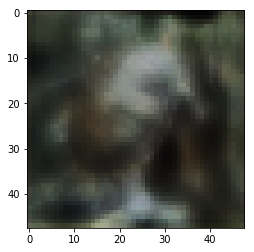

300it [01:17,  3.95it/s]

Epoch:  5 | train loss: 0.0059
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


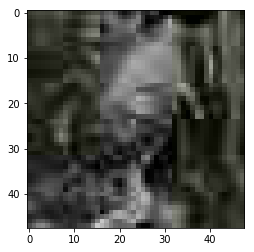

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

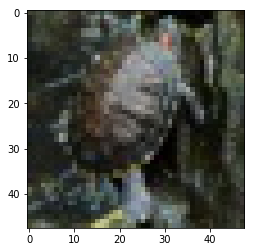

tensor([[[0.2591, 0.2109, 0.2512,  ..., 0.2740, 0.2088, 0.2198],
         [0.1949, 0.1737, 0.2145,  ..., 0.2956, 0.2397, 0.2345],
         [0.1919, 0.1716, 0.2118,  ..., 0.3420, 0.2982, 0.2869],
         ...,
         [0.2573, 0.2082, 0.1996,  ..., 0.1985, 0.2132, 0.2281],
         [0.3045, 0.2570, 0.2631,  ..., 0.1909, 0.2157, 0.2170],
         [0.3790, 0.3533, 0.3513,  ..., 0.2093, 0.2435, 0.2714]],

        [[0.2598, 0.2092, 0.2544,  ..., 0.2775, 0.2140, 0.2110],
         [0.1949, 0.1902, 0.2342,  ..., 0.3319, 0.2596, 0.2324],
         [0.1933, 0.1903, 0.2338,  ..., 0.3742, 0.3202, 0.2915],
         ...,
         [0.2691, 0.2436, 0.2224,  ..., 0.2021, 0.2121, 0.2245],
         [0.3147, 0.2984, 0.2942,  ..., 0.2096, 0.2311, 0.2291],
         [0.4069, 0.3891, 0.3767,  ..., 0.2288, 0.2465, 0.2682]],

        [[0.2061, 0.1867, 0.2151,  ..., 0.2194, 0.1759, 0.1927],
         [0.1568, 0.1573, 0.1862,  ..., 0.2378, 0.1991, 0.1869],
         [0.1575, 0.1611, 0.1903,  ..., 0.2846, 0.2534, 0.

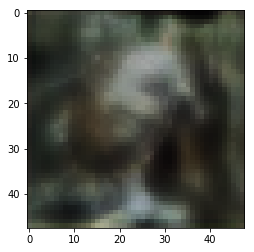

313it [01:21,  4.67it/s]
0it [00:00, ?it/s]

Epoch:  6 | train loss: 0.0059
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


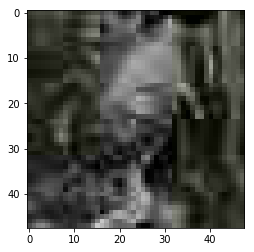

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

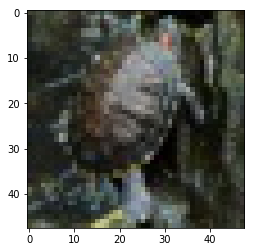

tensor([[[0.2542, 0.2059, 0.2471,  ..., 0.2704, 0.2045, 0.2148],
         [0.1927, 0.1717, 0.2129,  ..., 0.2944, 0.2365, 0.2287],
         [0.1911, 0.1711, 0.2110,  ..., 0.3415, 0.2950, 0.2800],
         ...,
         [0.2609, 0.2136, 0.2052,  ..., 0.2021, 0.2160, 0.2282],
         [0.3077, 0.2620, 0.2689,  ..., 0.2003, 0.2241, 0.2213],
         [0.3823, 0.3595, 0.3587,  ..., 0.2232, 0.2564, 0.2793]],

        [[0.2562, 0.2052, 0.2508,  ..., 0.2728, 0.2092, 0.2063],
         [0.1933, 0.1893, 0.2345,  ..., 0.3313, 0.2566, 0.2272],
         [0.1934, 0.1911, 0.2348,  ..., 0.3739, 0.3168, 0.2848],
         ...,
         [0.2738, 0.2502, 0.2288,  ..., 0.2061, 0.2151, 0.2246],
         [0.3192, 0.3049, 0.3013,  ..., 0.2202, 0.2404, 0.2339],
         [0.4104, 0.3951, 0.3836,  ..., 0.2444, 0.2601, 0.2765]],

        [[0.2005, 0.1811, 0.2098,  ..., 0.2127, 0.1689, 0.1858],
         [0.1535, 0.1540, 0.1834,  ..., 0.2325, 0.1917, 0.1789],
         [0.1555, 0.1592, 0.1881,  ..., 0.2793, 0.2451, 0.

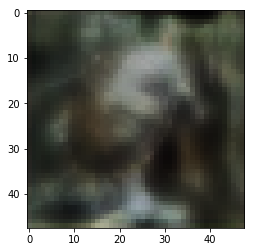

100it [00:26,  4.02it/s]

Epoch:  6 | train loss: 0.0052
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


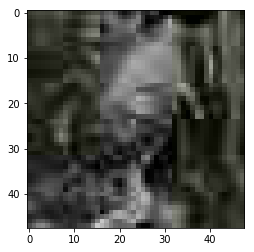

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

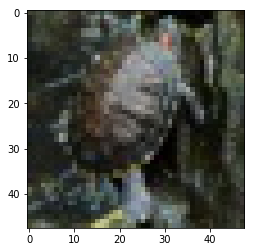

tensor([[[0.2566, 0.2087, 0.2494,  ..., 0.2710, 0.2053, 0.2159],
         [0.1939, 0.1732, 0.2143,  ..., 0.2945, 0.2372, 0.2302],
         [0.1915, 0.1715, 0.2115,  ..., 0.3412, 0.2955, 0.2817],
         ...,
         [0.2601, 0.2126, 0.2040,  ..., 0.1998, 0.2141, 0.2274],
         [0.3067, 0.2607, 0.2672,  ..., 0.1964, 0.2205, 0.2192],
         [0.3809, 0.3572, 0.3559,  ..., 0.2183, 0.2518, 0.2762]],

        [[0.2575, 0.2067, 0.2520,  ..., 0.2729, 0.2095, 0.2070],
         [0.1937, 0.1892, 0.2335,  ..., 0.3297, 0.2561, 0.2281],
         [0.1927, 0.1898, 0.2331,  ..., 0.3720, 0.3162, 0.2860],
         ...,
         [0.2717, 0.2478, 0.2264,  ..., 0.2028, 0.2124, 0.2237],
         [0.3170, 0.3021, 0.2981,  ..., 0.2149, 0.2357, 0.2315],
         [0.4084, 0.3920, 0.3800,  ..., 0.2381, 0.2545, 0.2731]],

        [[0.2029, 0.1838, 0.2123,  ..., 0.2144, 0.1706, 0.1876],
         [0.1550, 0.1557, 0.1849,  ..., 0.2339, 0.1937, 0.1811],
         [0.1563, 0.1601, 0.1891,  ..., 0.2806, 0.2473, 0.

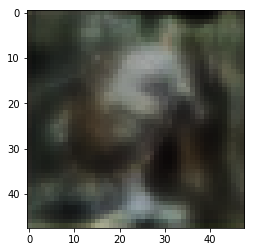

200it [00:51,  3.96it/s]

Epoch:  6 | train loss: 0.0060
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


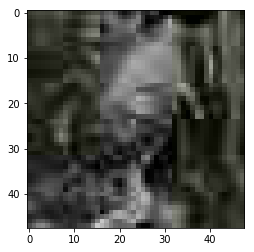

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

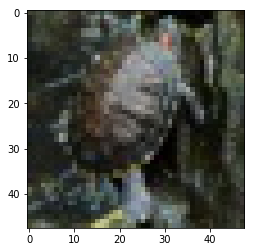

tensor([[[0.2580, 0.2103, 0.2506,  ..., 0.2709, 0.2053, 0.2162],
         [0.1945, 0.1742, 0.2154,  ..., 0.2947, 0.2375, 0.2308],
         [0.1916, 0.1718, 0.2121,  ..., 0.3411, 0.2957, 0.2824],
         ...,
         [0.2593, 0.2118, 0.2032,  ..., 0.1994, 0.2140, 0.2278],
         [0.3057, 0.2597, 0.2662,  ..., 0.1954, 0.2197, 0.2190],
         [0.3801, 0.3564, 0.3551,  ..., 0.2170, 0.2506, 0.2756]],

        [[0.2589, 0.2084, 0.2532,  ..., 0.2728, 0.2094, 0.2072],
         [0.1946, 0.1905, 0.2346,  ..., 0.3300, 0.2564, 0.2289],
         [0.1929, 0.1905, 0.2339,  ..., 0.3722, 0.3166, 0.2869],
         ...,
         [0.2708, 0.2471, 0.2257,  ..., 0.2031, 0.2129, 0.2245],
         [0.3160, 0.3013, 0.2974,  ..., 0.2145, 0.2355, 0.2316],
         [0.4078, 0.3914, 0.3795,  ..., 0.2370, 0.2536, 0.2726]],

        [[0.2043, 0.1854, 0.2139,  ..., 0.2148, 0.1709, 0.1880],
         [0.1559, 0.1572, 0.1865,  ..., 0.2348, 0.1945, 0.1820],
         [0.1566, 0.1610, 0.1901,  ..., 0.2815, 0.2483, 0.

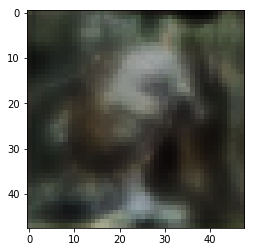

300it [01:18,  3.89it/s]

Epoch:  6 | train loss: 0.0065
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


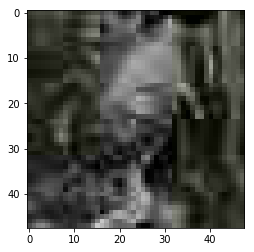

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

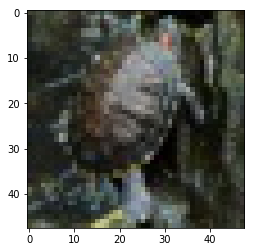

tensor([[[0.2585, 0.2109, 0.2512,  ..., 0.2718, 0.2063, 0.2174],
         [0.1951, 0.1750, 0.2163,  ..., 0.2965, 0.2394, 0.2327],
         [0.1921, 0.1725, 0.2128,  ..., 0.3431, 0.2979, 0.2847],
         ...,
         [0.2605, 0.2136, 0.2051,  ..., 0.2008, 0.2159, 0.2301],
         [0.3070, 0.2615, 0.2681,  ..., 0.1980, 0.2226, 0.2215],
         [0.3811, 0.3578, 0.3566,  ..., 0.2200, 0.2538, 0.2780]],

        [[0.2593, 0.2087, 0.2535,  ..., 0.2731, 0.2097, 0.2079],
         [0.1950, 0.1908, 0.2349,  ..., 0.3309, 0.2575, 0.2304],
         [0.1932, 0.1907, 0.2340,  ..., 0.3733, 0.3179, 0.2889],
         ...,
         [0.2718, 0.2487, 0.2274,  ..., 0.2038, 0.2141, 0.2265],
         [0.3172, 0.3030, 0.2993,  ..., 0.2165, 0.2378, 0.2340],
         [0.4085, 0.3925, 0.3806,  ..., 0.2399, 0.2564, 0.2751]],

        [[0.2044, 0.1855, 0.2138,  ..., 0.2150, 0.1713, 0.1888],
         [0.1560, 0.1573, 0.1864,  ..., 0.2354, 0.1952, 0.1832],
         [0.1567, 0.1609, 0.1898,  ..., 0.2820, 0.2491, 0.

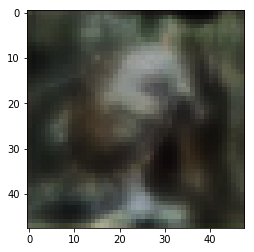

313it [01:21,  4.51it/s]
0it [00:00, ?it/s]

Epoch:  7 | train loss: 0.0060
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


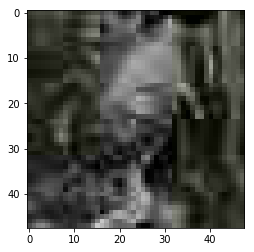

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

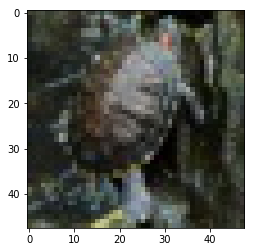

tensor([[[0.2576, 0.2098, 0.2501,  ..., 0.2710, 0.2057, 0.2169],
         [0.1941, 0.1736, 0.2146,  ..., 0.2950, 0.2383, 0.2320],
         [0.1912, 0.1711, 0.2110,  ..., 0.3413, 0.2965, 0.2838],
         ...,
         [0.2592, 0.2120, 0.2034,  ..., 0.1992, 0.2146, 0.2293],
         [0.3056, 0.2597, 0.2661,  ..., 0.1964, 0.2212, 0.2206],
         [0.3799, 0.3560, 0.3546,  ..., 0.2185, 0.2524, 0.2771]],

        [[0.2593, 0.2088, 0.2537,  ..., 0.2735, 0.2100, 0.2080],
         [0.1950, 0.1909, 0.2351,  ..., 0.3312, 0.2578, 0.2305],
         [0.1935, 0.1910, 0.2342,  ..., 0.3735, 0.3182, 0.2890],
         ...,
         [0.2718, 0.2489, 0.2277,  ..., 0.2042, 0.2145, 0.2268],
         [0.3170, 0.3030, 0.2993,  ..., 0.2168, 0.2380, 0.2342],
         [0.4082, 0.3920, 0.3801,  ..., 0.2397, 0.2563, 0.2750]],

        [[0.2042, 0.1854, 0.2139,  ..., 0.2151, 0.1714, 0.1888],
         [0.1558, 0.1572, 0.1864,  ..., 0.2353, 0.1953, 0.1832],
         [0.1567, 0.1610, 0.1899,  ..., 0.2819, 0.2492, 0.

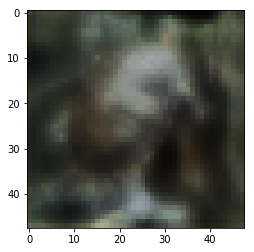

100it [00:27,  3.86it/s]

Epoch:  7 | train loss: 0.0056
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


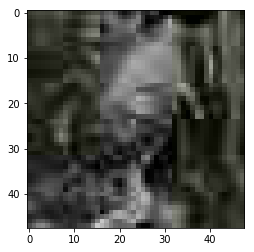

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

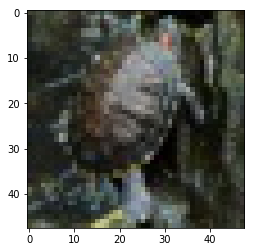

tensor([[[0.2569, 0.2096, 0.2503,  ..., 0.2699, 0.2046, 0.2160],
         [0.1944, 0.1744, 0.2158,  ..., 0.2945, 0.2376, 0.2312],
         [0.1916, 0.1721, 0.2122,  ..., 0.3410, 0.2959, 0.2830],
         ...,
         [0.2595, 0.2124, 0.2039,  ..., 0.2002, 0.2156, 0.2300],
         [0.3061, 0.2605, 0.2671,  ..., 0.1975, 0.2223, 0.2214],
         [0.3807, 0.3575, 0.3564,  ..., 0.2199, 0.2538, 0.2780]],

        [[0.2579, 0.2076, 0.2529,  ..., 0.2715, 0.2081, 0.2066],
         [0.1943, 0.1907, 0.2352,  ..., 0.3303, 0.2565, 0.2295],
         [0.1930, 0.1911, 0.2345,  ..., 0.3730, 0.3173, 0.2881],
         ...,
         [0.2712, 0.2485, 0.2274,  ..., 0.2048, 0.2150, 0.2274],
         [0.3167, 0.3031, 0.2996,  ..., 0.2174, 0.2386, 0.2346],
         [0.4086, 0.3929, 0.3814,  ..., 0.2407, 0.2571, 0.2756]],

        [[0.2032, 0.1847, 0.2133,  ..., 0.2140, 0.1703, 0.1878],
         [0.1556, 0.1572, 0.1864,  ..., 0.2349, 0.1946, 0.1824],
         [0.1567, 0.1612, 0.1901,  ..., 0.2819, 0.2488, 0.

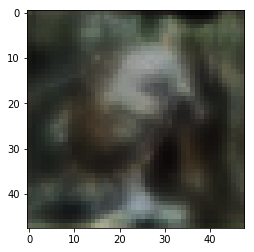

200it [00:53,  3.86it/s]

Epoch:  7 | train loss: 0.0065
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


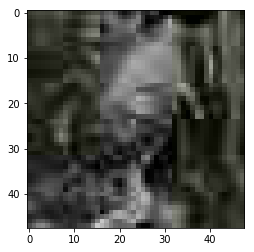

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

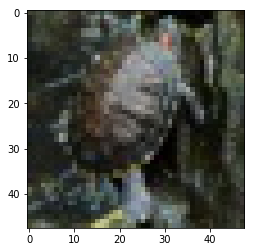

tensor([[[0.2570, 0.2097, 0.2508,  ..., 0.2701, 0.2045, 0.2155],
         [0.1948, 0.1747, 0.2163,  ..., 0.2951, 0.2377, 0.2306],
         [0.1924, 0.1726, 0.2128,  ..., 0.3418, 0.2960, 0.2821],
         ...,
         [0.2596, 0.2121, 0.2032,  ..., 0.1998, 0.2146, 0.2283],
         [0.3061, 0.2602, 0.2664,  ..., 0.1954, 0.2200, 0.2192],
         [0.3801, 0.3562, 0.3547,  ..., 0.2163, 0.2503, 0.2755]],

        [[0.2583, 0.2080, 0.2536,  ..., 0.2717, 0.2080, 0.2062],
         [0.1946, 0.1908, 0.2352,  ..., 0.3304, 0.2563, 0.2287],
         [0.1938, 0.1914, 0.2346,  ..., 0.3732, 0.3169, 0.2869],
         ...,
         [0.2713, 0.2481, 0.2267,  ..., 0.2046, 0.2139, 0.2253],
         [0.3167, 0.3027, 0.2987,  ..., 0.2154, 0.2361, 0.2321],
         [0.4081, 0.3917, 0.3797,  ..., 0.2369, 0.2534, 0.2728]],

        [[0.2036, 0.1851, 0.2139,  ..., 0.2139, 0.1699, 0.1872],
         [0.1561, 0.1574, 0.1867,  ..., 0.2348, 0.1941, 0.1816],
         [0.1574, 0.1617, 0.1905,  ..., 0.2818, 0.2480, 0.

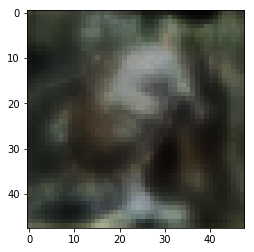

300it [01:19,  3.93it/s]

Epoch:  7 | train loss: 0.0060
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


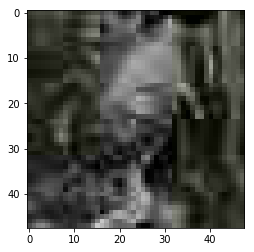

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

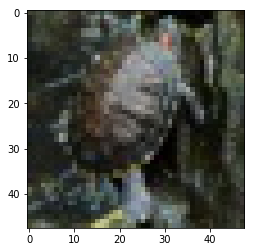

tensor([[[0.2566, 0.2094, 0.2509,  ..., 0.2683, 0.2029, 0.2143],
         [0.1949, 0.1752, 0.2172,  ..., 0.2940, 0.2366, 0.2297],
         [0.1928, 0.1734, 0.2139,  ..., 0.3413, 0.2953, 0.2815],
         ...,
         [0.2593, 0.2119, 0.2031,  ..., 0.2005, 0.2152, 0.2290],
         [0.3057, 0.2599, 0.2661,  ..., 0.1965, 0.2209, 0.2198],
         [0.3801, 0.3567, 0.3554,  ..., 0.2179, 0.2516, 0.2762]],

        [[0.2575, 0.2074, 0.2531,  ..., 0.2695, 0.2059, 0.2047],
         [0.1942, 0.1906, 0.2353,  ..., 0.3290, 0.2547, 0.2277],
         [0.1938, 0.1916, 0.2350,  ..., 0.3722, 0.3157, 0.2861],
         ...,
         [0.2708, 0.2477, 0.2261,  ..., 0.2046, 0.2139, 0.2256],
         [0.3161, 0.3020, 0.2980,  ..., 0.2160, 0.2364, 0.2324],
         [0.4080, 0.3918, 0.3799,  ..., 0.2382, 0.2542, 0.2732]],

        [[0.2033, 0.1851, 0.2142,  ..., 0.2127, 0.1688, 0.1864],
         [0.1563, 0.1581, 0.1878,  ..., 0.2346, 0.1937, 0.1811],
         [0.1580, 0.1628, 0.1921,  ..., 0.2823, 0.2482, 0.

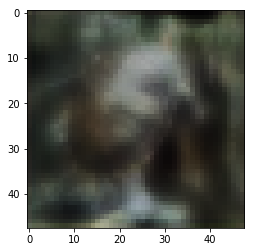

313it [01:23,  4.52it/s]
0it [00:00, ?it/s]

Epoch:  8 | train loss: 0.0062
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


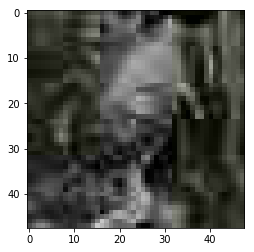

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

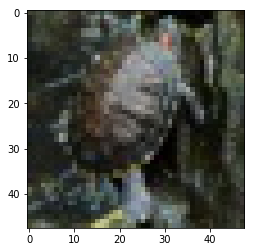

tensor([[[0.2564, 0.2094, 0.2511,  ..., 0.2686, 0.2029, 0.2141],
         [0.1949, 0.1753, 0.2175,  ..., 0.2945, 0.2368, 0.2294],
         [0.1929, 0.1736, 0.2143,  ..., 0.3420, 0.2957, 0.2812],
         ...,
         [0.2594, 0.2120, 0.2032,  ..., 0.2006, 0.2151, 0.2284],
         [0.3058, 0.2601, 0.2664,  ..., 0.1966, 0.2208, 0.2194],
         [0.3801, 0.3568, 0.3555,  ..., 0.2179, 0.2515, 0.2759]],

        [[0.2574, 0.2074, 0.2534,  ..., 0.2695, 0.2058, 0.2045],
         [0.1942, 0.1907, 0.2356,  ..., 0.3293, 0.2547, 0.2273],
         [0.1938, 0.1918, 0.2352,  ..., 0.3727, 0.3157, 0.2856],
         ...,
         [0.2708, 0.2477, 0.2262,  ..., 0.2048, 0.2138, 0.2250],
         [0.3161, 0.3022, 0.2982,  ..., 0.2163, 0.2364, 0.2320],
         [0.4080, 0.3919, 0.3799,  ..., 0.2383, 0.2542, 0.2729]],

        [[0.2028, 0.1846, 0.2137,  ..., 0.2120, 0.1681, 0.1858],
         [0.1558, 0.1574, 0.1870,  ..., 0.2336, 0.1927, 0.1803],
         [0.1575, 0.1620, 0.1912,  ..., 0.2813, 0.2470, 0.

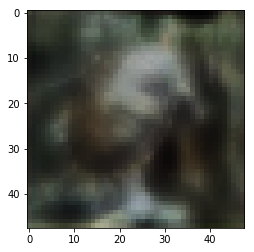

100it [00:26,  3.93it/s]

Epoch:  8 | train loss: 0.0066
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


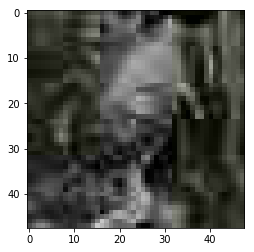

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

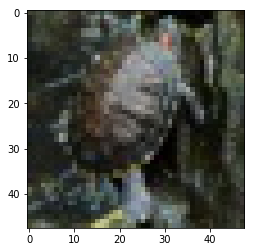

tensor([[[0.2543, 0.2075, 0.2501,  ..., 0.2679, 0.2024, 0.2138],
         [0.1941, 0.1747, 0.2173,  ..., 0.2947, 0.2368, 0.2292],
         [0.1924, 0.1734, 0.2140,  ..., 0.3423, 0.2958, 0.2808],
         ...,
         [0.2586, 0.2112, 0.2022,  ..., 0.2006, 0.2153, 0.2284],
         [0.3053, 0.2597, 0.2659,  ..., 0.1972, 0.2217, 0.2201],
         [0.3802, 0.3571, 0.3559,  ..., 0.2191, 0.2530, 0.2770]],

        [[0.2549, 0.2051, 0.2517,  ..., 0.2677, 0.2044, 0.2037],
         [0.1925, 0.1897, 0.2352,  ..., 0.3291, 0.2542, 0.2268],
         [0.1928, 0.1914, 0.2351,  ..., 0.3729, 0.3155, 0.2853],
         ...,
         [0.2695, 0.2465, 0.2250,  ..., 0.2049, 0.2140, 0.2252],
         [0.3151, 0.3014, 0.2975,  ..., 0.2169, 0.2372, 0.2328],
         [0.4078, 0.3920, 0.3802,  ..., 0.2395, 0.2555, 0.2740]],

        [[0.2009, 0.1828, 0.2123,  ..., 0.2108, 0.1671, 0.1851],
         [0.1548, 0.1564, 0.1862,  ..., 0.2331, 0.1919, 0.1796],
         [0.1569, 0.1614, 0.1904,  ..., 0.2808, 0.2463, 0.

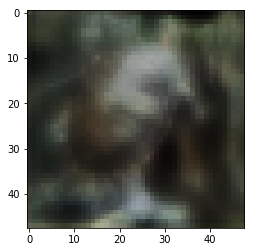

200it [00:52,  3.87it/s]

Epoch:  8 | train loss: 0.0067
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


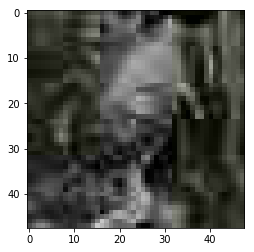

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

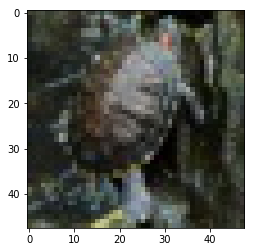

tensor([[[0.2556, 0.2090, 0.2516,  ..., 0.2683, 0.2028, 0.2142],
         [0.1953, 0.1761, 0.2188,  ..., 0.2952, 0.2375, 0.2299],
         [0.1937, 0.1748, 0.2156,  ..., 0.3429, 0.2965, 0.2817],
         ...,
         [0.2599, 0.2127, 0.2035,  ..., 0.2013, 0.2158, 0.2287],
         [0.3066, 0.2612, 0.2673,  ..., 0.1971, 0.2214, 0.2198],
         [0.3808, 0.3577, 0.3563,  ..., 0.2178, 0.2515, 0.2760]],

        [[0.2565, 0.2067, 0.2534,  ..., 0.2683, 0.2048, 0.2041],
         [0.1937, 0.1907, 0.2360,  ..., 0.3295, 0.2548, 0.2276],
         [0.1940, 0.1923, 0.2356,  ..., 0.3732, 0.3162, 0.2862],
         ...,
         [0.2707, 0.2478, 0.2259,  ..., 0.2059, 0.2147, 0.2256],
         [0.3164, 0.3028, 0.2987,  ..., 0.2172, 0.2372, 0.2326],
         [0.4084, 0.3925, 0.3805,  ..., 0.2383, 0.2544, 0.2733]],

        [[0.2015, 0.1834, 0.2127,  ..., 0.2109, 0.1674, 0.1855],
         [0.1551, 0.1564, 0.1860,  ..., 0.2331, 0.1924, 0.1804],
         [0.1571, 0.1612, 0.1899,  ..., 0.2807, 0.2467, 0.

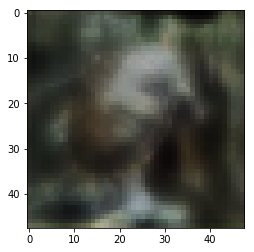

300it [01:18,  3.96it/s]

Epoch:  8 | train loss: 0.0062
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


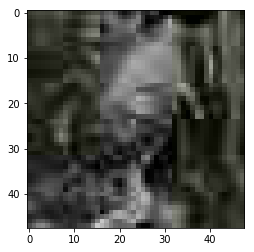

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

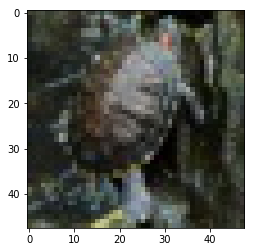

tensor([[[0.2556, 0.2089, 0.2509,  ..., 0.2671, 0.2018, 0.2137],
         [0.1947, 0.1754, 0.2178,  ..., 0.2941, 0.2366, 0.2297],
         [0.1927, 0.1736, 0.2143,  ..., 0.3420, 0.2958, 0.2817],
         ...,
         [0.2596, 0.2126, 0.2035,  ..., 0.2008, 0.2156, 0.2292],
         [0.3063, 0.2610, 0.2673,  ..., 0.1972, 0.2214, 0.2201],
         [0.3809, 0.3583, 0.3571,  ..., 0.2188, 0.2523, 0.2764]],

        [[0.2563, 0.2064, 0.2525,  ..., 0.2667, 0.2033, 0.2033],
         [0.1934, 0.1900, 0.2346,  ..., 0.3278, 0.2532, 0.2271],
         [0.1932, 0.1910, 0.2338,  ..., 0.3714, 0.3146, 0.2861],
         ...,
         [0.2703, 0.2476, 0.2258,  ..., 0.2050, 0.2141, 0.2260],
         [0.3161, 0.3026, 0.2985,  ..., 0.2168, 0.2367, 0.2327],
         [0.4084, 0.3927, 0.3808,  ..., 0.2388, 0.2545, 0.2734]],

        [[0.2020, 0.1840, 0.2131,  ..., 0.2108, 0.1672, 0.1855],
         [0.1554, 0.1570, 0.1864,  ..., 0.2336, 0.1926, 0.1808],
         [0.1571, 0.1615, 0.1902,  ..., 0.2815, 0.2474, 0.

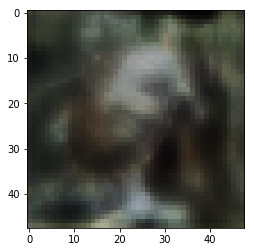

313it [01:22,  4.41it/s]
0it [00:00, ?it/s]

Epoch:  9 | train loss: 0.0058
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


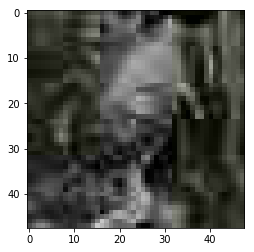

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

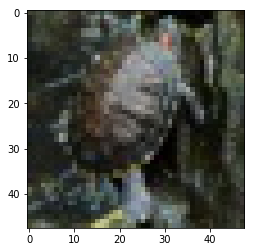

tensor([[[0.2562, 0.2096, 0.2516,  ..., 0.2685, 0.2033, 0.2152],
         [0.1952, 0.1760, 0.2186,  ..., 0.2960, 0.2386, 0.2317],
         [0.1931, 0.1740, 0.2149,  ..., 0.3438, 0.2979, 0.2841],
         ...,
         [0.2607, 0.2143, 0.2055,  ..., 0.2019, 0.2172, 0.2312],
         [0.3070, 0.2621, 0.2686,  ..., 0.1990, 0.2236, 0.2220],
         [0.3810, 0.3583, 0.3572,  ..., 0.2207, 0.2543, 0.2781]],

        [[0.2572, 0.2073, 0.2533,  ..., 0.2683, 0.2048, 0.2048],
         [0.1941, 0.1907, 0.2353,  ..., 0.3295, 0.2553, 0.2293],
         [0.1938, 0.1915, 0.2344,  ..., 0.3730, 0.3168, 0.2886],
         ...,
         [0.2717, 0.2498, 0.2283,  ..., 0.2062, 0.2158, 0.2283],
         [0.3171, 0.3043, 0.3005,  ..., 0.2189, 0.2391, 0.2350],
         [0.4086, 0.3930, 0.3812,  ..., 0.2411, 0.2567, 0.2753]],

        [[0.2022, 0.1841, 0.2131,  ..., 0.2114, 0.1681, 0.1866],
         [0.1553, 0.1568, 0.1861,  ..., 0.2340, 0.1935, 0.1823],
         [0.1569, 0.1612, 0.1896,  ..., 0.2814, 0.2481, 0.

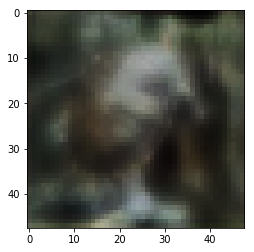

100it [00:25,  3.94it/s]

Epoch:  9 | train loss: 0.0063
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


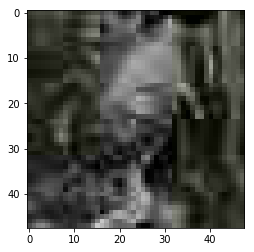

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

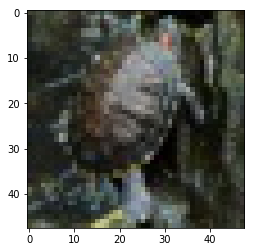

tensor([[[0.2555, 0.2087, 0.2508,  ..., 0.2675, 0.2025, 0.2145],
         [0.1944, 0.1749, 0.2174,  ..., 0.2944, 0.2373, 0.2307],
         [0.1923, 0.1730, 0.2136,  ..., 0.3420, 0.2964, 0.2829],
         ...,
         [0.2594, 0.2126, 0.2036,  ..., 0.2001, 0.2153, 0.2295],
         [0.3057, 0.2604, 0.2666,  ..., 0.1966, 0.2212, 0.2202],
         [0.3799, 0.3566, 0.3552,  ..., 0.2179, 0.2516, 0.2762]],

        [[0.2569, 0.2071, 0.2532,  ..., 0.2679, 0.2044, 0.2043],
         [0.1937, 0.1903, 0.2349,  ..., 0.3289, 0.2547, 0.2286],
         [0.1935, 0.1912, 0.2340,  ..., 0.3724, 0.3162, 0.2878],
         ...,
         [0.2710, 0.2489, 0.2272,  ..., 0.2055, 0.2149, 0.2272],
         [0.3163, 0.3033, 0.2994,  ..., 0.2173, 0.2375, 0.2336],
         [0.4079, 0.3920, 0.3800,  ..., 0.2388, 0.2546, 0.2738]],

        [[0.2020, 0.1840, 0.2131,  ..., 0.2112, 0.1678, 0.1863],
         [0.1552, 0.1566, 0.1859,  ..., 0.2335, 0.1931, 0.1818],
         [0.1568, 0.1611, 0.1895,  ..., 0.2811, 0.2477, 0.

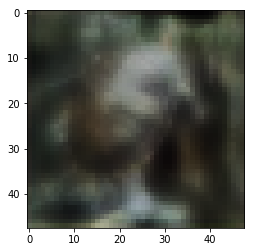

200it [00:51,  3.96it/s]

Epoch:  9 | train loss: 0.0065
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


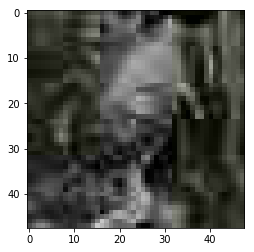

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

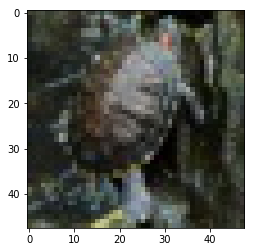

tensor([[[0.2551, 0.2084, 0.2508,  ..., 0.2673, 0.2021, 0.2141],
         [0.1943, 0.1750, 0.2175,  ..., 0.2943, 0.2370, 0.2302],
         [0.1924, 0.1732, 0.2139,  ..., 0.3421, 0.2962, 0.2824],
         ...,
         [0.2593, 0.2125, 0.2035,  ..., 0.2001, 0.2152, 0.2291],
         [0.3056, 0.2603, 0.2666,  ..., 0.1963, 0.2208, 0.2198],
         [0.3798, 0.3565, 0.3551,  ..., 0.2174, 0.2511, 0.2757]],

        [[0.2563, 0.2065, 0.2529,  ..., 0.2673, 0.2039, 0.2038],
         [0.1933, 0.1899, 0.2347,  ..., 0.3284, 0.2541, 0.2279],
         [0.1934, 0.1911, 0.2340,  ..., 0.3721, 0.3157, 0.2871],
         ...,
         [0.2707, 0.2485, 0.2269,  ..., 0.2053, 0.2145, 0.2265],
         [0.3161, 0.3030, 0.2990,  ..., 0.2168, 0.2369, 0.2329],
         [0.4077, 0.3918, 0.3797,  ..., 0.2381, 0.2539, 0.2731]],

        [[0.2016, 0.1837, 0.2129,  ..., 0.2107, 0.1674, 0.1858],
         [0.1550, 0.1564, 0.1858,  ..., 0.2332, 0.1927, 0.1812],
         [0.1568, 0.1611, 0.1896,  ..., 0.2809, 0.2473, 0.

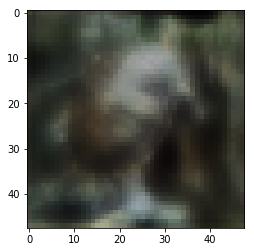

300it [01:17,  3.96it/s]

Epoch:  9 | train loss: 0.0072
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],


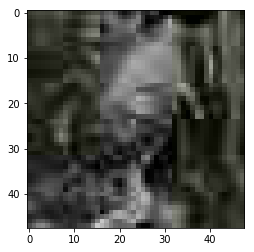

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

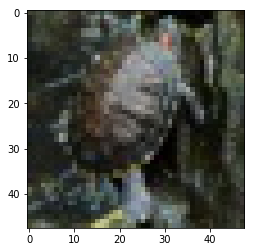

tensor([[[0.2551, 0.2085, 0.2509,  ..., 0.2673, 0.2022, 0.2141],
         [0.1944, 0.1750, 0.2177,  ..., 0.2944, 0.2372, 0.2303],
         [0.1925, 0.1733, 0.2140,  ..., 0.3423, 0.2964, 0.2824],
         ...,
         [0.2593, 0.2126, 0.2038,  ..., 0.2001, 0.2152, 0.2290],
         [0.3055, 0.2603, 0.2665,  ..., 0.1961, 0.2206, 0.2196],
         [0.3795, 0.3561, 0.3547,  ..., 0.2170, 0.2507, 0.2754]],

        [[0.2563, 0.2065, 0.2530,  ..., 0.2673, 0.2039, 0.2038],
         [0.1933, 0.1899, 0.2347,  ..., 0.3284, 0.2541, 0.2280],
         [0.1933, 0.1911, 0.2340,  ..., 0.3722, 0.3157, 0.2870],
         ...,
         [0.2707, 0.2487, 0.2271,  ..., 0.2053, 0.2144, 0.2264],
         [0.3159, 0.3029, 0.2990,  ..., 0.2166, 0.2366, 0.2327],
         [0.4075, 0.3914, 0.3793,  ..., 0.2377, 0.2535, 0.2728]],

        [[0.2015, 0.1835, 0.2127,  ..., 0.2104, 0.1671, 0.1857],
         [0.1548, 0.1561, 0.1854,  ..., 0.2327, 0.1923, 0.1810],
         [0.1566, 0.1607, 0.1891,  ..., 0.2804, 0.2468, 0.

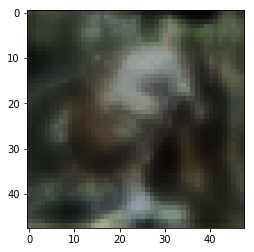

313it [01:21,  4.57it/s]
0it [00:00, ?it/s]

Epoch:  10 | train loss: 0.0064
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

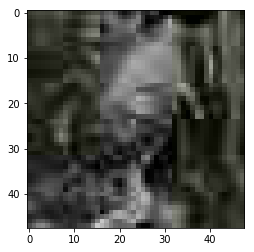

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

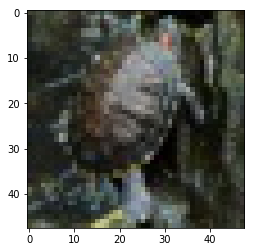

tensor([[[0.2552, 0.2086, 0.2509,  ..., 0.2673, 0.2022, 0.2142],
         [0.1944, 0.1751, 0.2177,  ..., 0.2944, 0.2372, 0.2304],
         [0.1925, 0.1733, 0.2141,  ..., 0.3423, 0.2965, 0.2826],
         ...,
         [0.2594, 0.2127, 0.2039,  ..., 0.2001, 0.2152, 0.2292],
         [0.3056, 0.2603, 0.2666,  ..., 0.1962, 0.2207, 0.2197],
         [0.3795, 0.3561, 0.3546,  ..., 0.2171, 0.2508, 0.2755]],

        [[0.2564, 0.2067, 0.2531,  ..., 0.2674, 0.2040, 0.2040],
         [0.1934, 0.1900, 0.2348,  ..., 0.3286, 0.2543, 0.2282],
         [0.1934, 0.1912, 0.2341,  ..., 0.3724, 0.3159, 0.2873],
         ...,
         [0.2709, 0.2490, 0.2275,  ..., 0.2055, 0.2147, 0.2267],
         [0.3161, 0.3032, 0.2993,  ..., 0.2169, 0.2369, 0.2330],
         [0.4076, 0.3915, 0.3795,  ..., 0.2379, 0.2537, 0.2730]],

        [[0.2016, 0.1835, 0.2128,  ..., 0.2105, 0.1672, 0.1858],
         [0.1549, 0.1562, 0.1855,  ..., 0.2328, 0.1924, 0.1812],
         [0.1567, 0.1608, 0.1892,  ..., 0.2805, 0.2469, 0.

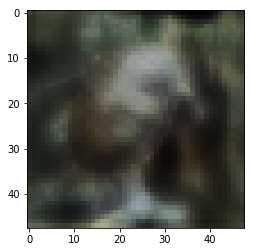

100it [00:25,  3.99it/s]

Epoch:  10 | train loss: 0.0058
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

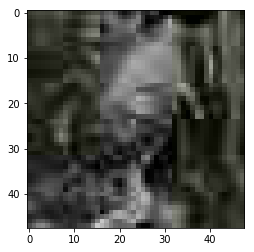

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

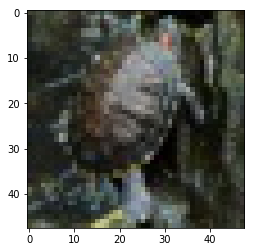

tensor([[[0.2549, 0.2083, 0.2508,  ..., 0.2670, 0.2019, 0.2139],
         [0.1943, 0.1750, 0.2177,  ..., 0.2940, 0.2369, 0.2300],
         [0.1925, 0.1734, 0.2140,  ..., 0.3419, 0.2961, 0.2821],
         ...,
         [0.2595, 0.2128, 0.2038,  ..., 0.1999, 0.2150, 0.2290],
         [0.3057, 0.2604, 0.2665,  ..., 0.1960, 0.2205, 0.2195],
         [0.3796, 0.3561, 0.3546,  ..., 0.2169, 0.2506, 0.2754]],

        [[0.2561, 0.2064, 0.2530,  ..., 0.2670, 0.2036, 0.2037],
         [0.1933, 0.1901, 0.2349,  ..., 0.3284, 0.2541, 0.2278],
         [0.1935, 0.1914, 0.2343,  ..., 0.3722, 0.3157, 0.2870],
         ...,
         [0.2710, 0.2492, 0.2275,  ..., 0.2055, 0.2147, 0.2266],
         [0.3163, 0.3033, 0.2994,  ..., 0.2169, 0.2368, 0.2329],
         [0.4077, 0.3916, 0.3795,  ..., 0.2378, 0.2536, 0.2729]],

        [[0.2013, 0.1833, 0.2126,  ..., 0.2102, 0.1669, 0.1855],
         [0.1548, 0.1561, 0.1855,  ..., 0.2326, 0.1922, 0.1808],
         [0.1567, 0.1609, 0.1893,  ..., 0.2804, 0.2468, 0.

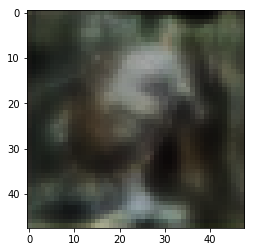

200it [00:51,  4.00it/s]

Epoch:  10 | train loss: 0.0060
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

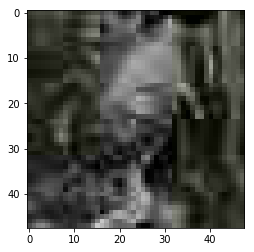

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

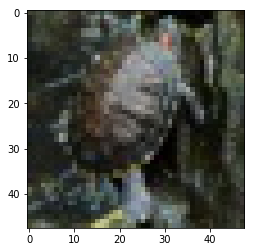

tensor([[[0.2547, 0.2082, 0.2508,  ..., 0.2672, 0.2020, 0.2140],
         [0.1943, 0.1751, 0.2178,  ..., 0.2945, 0.2372, 0.2302],
         [0.1926, 0.1735, 0.2142,  ..., 0.3424, 0.2964, 0.2823],
         ...,
         [0.2593, 0.2126, 0.2036,  ..., 0.2003, 0.2153, 0.2291],
         [0.3056, 0.2604, 0.2667,  ..., 0.1964, 0.2209, 0.2198],
         [0.3797, 0.3565, 0.3551,  ..., 0.2174, 0.2511, 0.2757]],

        [[0.2560, 0.2063, 0.2529,  ..., 0.2671, 0.2037, 0.2037],
         [0.1932, 0.1900, 0.2350,  ..., 0.3287, 0.2542, 0.2279],
         [0.1935, 0.1914, 0.2344,  ..., 0.3726, 0.3159, 0.2871],
         ...,
         [0.2707, 0.2488, 0.2272,  ..., 0.2058, 0.2148, 0.2266],
         [0.3161, 0.3032, 0.2993,  ..., 0.2172, 0.2371, 0.2330],
         [0.4077, 0.3918, 0.3798,  ..., 0.2382, 0.2540, 0.2732]],

        [[0.2012, 0.1833, 0.2127,  ..., 0.2103, 0.1670, 0.1856],
         [0.1548, 0.1562, 0.1857,  ..., 0.2329, 0.1923, 0.1809],
         [0.1568, 0.1610, 0.1895,  ..., 0.2807, 0.2470, 0.

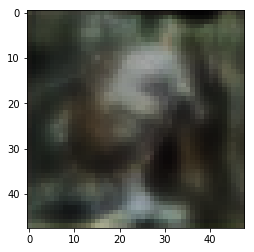

300it [01:17,  3.87it/s]

Epoch:  10 | train loss: 0.0062
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

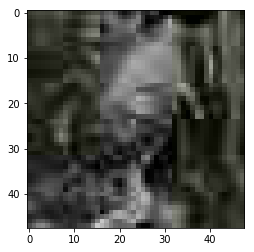

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

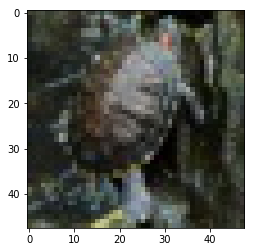

tensor([[[0.2551, 0.2085, 0.2509,  ..., 0.2671, 0.2020, 0.2141],
         [0.1944, 0.1751, 0.2178,  ..., 0.2942, 0.2371, 0.2303],
         [0.1925, 0.1734, 0.2141,  ..., 0.3421, 0.2962, 0.2824],
         ...,
         [0.2592, 0.2125, 0.2036,  ..., 0.1999, 0.2151, 0.2291],
         [0.3053, 0.2600, 0.2662,  ..., 0.1961, 0.2206, 0.2196],
         [0.3793, 0.3559, 0.3544,  ..., 0.2170, 0.2508, 0.2755]],

        [[0.2563, 0.2066, 0.2531,  ..., 0.2671, 0.2037, 0.2037],
         [0.1933, 0.1901, 0.2348,  ..., 0.3284, 0.2541, 0.2280],
         [0.1934, 0.1913, 0.2342,  ..., 0.3722, 0.3157, 0.2872],
         ...,
         [0.2706, 0.2487, 0.2272,  ..., 0.2054, 0.2146, 0.2266],
         [0.3158, 0.3028, 0.2990,  ..., 0.2168, 0.2367, 0.2328],
         [0.4074, 0.3913, 0.3793,  ..., 0.2378, 0.2536, 0.2729]],

        [[0.2017, 0.1838, 0.2131,  ..., 0.2106, 0.1672, 0.1858],
         [0.1551, 0.1566, 0.1860,  ..., 0.2332, 0.1927, 0.1813],
         [0.1569, 0.1613, 0.1898,  ..., 0.2810, 0.2473, 0.

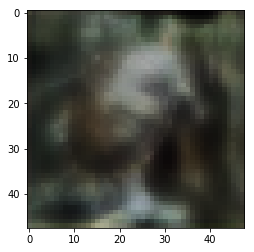

313it [01:21,  4.45it/s]
0it [00:00, ?it/s]

Epoch:  11 | train loss: 0.0062
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

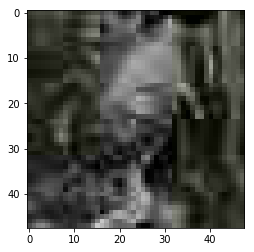

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

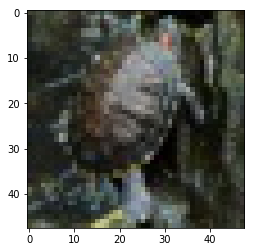

tensor([[[0.2550, 0.2084, 0.2508,  ..., 0.2670, 0.2019, 0.2140],
         [0.1943, 0.1750, 0.2177,  ..., 0.2941, 0.2369, 0.2301],
         [0.1924, 0.1733, 0.2140,  ..., 0.3419, 0.2961, 0.2822],
         ...,
         [0.2590, 0.2123, 0.2034,  ..., 0.1997, 0.2149, 0.2289],
         [0.3051, 0.2598, 0.2660,  ..., 0.1958, 0.2203, 0.2194],
         [0.3791, 0.3557, 0.3542,  ..., 0.2167, 0.2504, 0.2752]],

        [[0.2562, 0.2066, 0.2531,  ..., 0.2670, 0.2036, 0.2037],
         [0.1933, 0.1901, 0.2349,  ..., 0.3284, 0.2541, 0.2280],
         [0.1934, 0.1913, 0.2342,  ..., 0.3722, 0.3157, 0.2871],
         ...,
         [0.2706, 0.2487, 0.2272,  ..., 0.2054, 0.2146, 0.2265],
         [0.3157, 0.3028, 0.2989,  ..., 0.2167, 0.2367, 0.2328],
         [0.4073, 0.3912, 0.3792,  ..., 0.2376, 0.2534, 0.2728]],

        [[0.2015, 0.1836, 0.2129,  ..., 0.2104, 0.1671, 0.1857],
         [0.1549, 0.1563, 0.1857,  ..., 0.2329, 0.1924, 0.1811],
         [0.1568, 0.1610, 0.1895,  ..., 0.2807, 0.2470, 0.

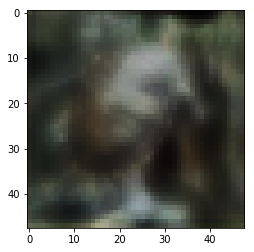

100it [00:26,  3.75it/s]

Epoch:  11 | train loss: 0.0060
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

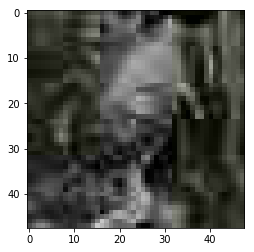

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

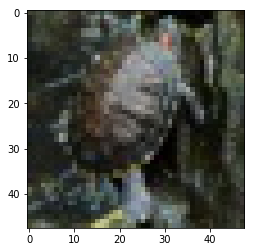

tensor([[[0.2546, 0.2082, 0.2511,  ..., 0.2670, 0.2018, 0.2136],
         [0.1945, 0.1754, 0.2184,  ..., 0.2947, 0.2371, 0.2297],
         [0.1929, 0.1739, 0.2148,  ..., 0.3428, 0.2963, 0.2817],
         ...,
         [0.2593, 0.2124, 0.2034,  ..., 0.2003, 0.2151, 0.2285],
         [0.3056, 0.2603, 0.2665,  ..., 0.1963, 0.2206, 0.2193],
         [0.3798, 0.3566, 0.3552,  ..., 0.2172, 0.2508, 0.2754]],

        [[0.2557, 0.2061, 0.2530,  ..., 0.2667, 0.2032, 0.2032],
         [0.1931, 0.1900, 0.2352,  ..., 0.3286, 0.2539, 0.2273],
         [0.1936, 0.1916, 0.2347,  ..., 0.3727, 0.3156, 0.2863],
         ...,
         [0.2706, 0.2487, 0.2270,  ..., 0.2059, 0.2145, 0.2258],
         [0.3160, 0.3031, 0.2992,  ..., 0.2170, 0.2367, 0.2323],
         [0.4077, 0.3919, 0.3799,  ..., 0.2380, 0.2536, 0.2727]],

        [[0.2010, 0.1832, 0.2127,  ..., 0.2099, 0.1665, 0.1850],
         [0.1549, 0.1563, 0.1859,  ..., 0.2327, 0.1918, 0.1803],
         [0.1570, 0.1613, 0.1899,  ..., 0.2807, 0.2464, 0.

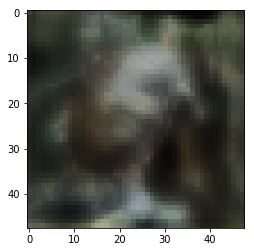

200it [00:54,  3.75it/s]

Epoch:  11 | train loss: 0.0060
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

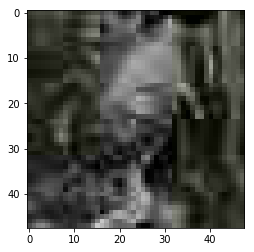

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

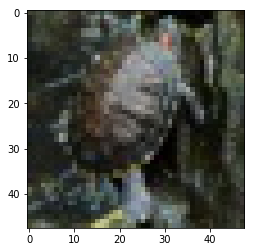

tensor([[[0.2549, 0.2085, 0.2510,  ..., 0.2668, 0.2018, 0.2139],
         [0.1944, 0.1752, 0.2179,  ..., 0.2941, 0.2369, 0.2301],
         [0.1926, 0.1735, 0.2142,  ..., 0.3420, 0.2962, 0.2822],
         ...,
         [0.2594, 0.2127, 0.2037,  ..., 0.1998, 0.2149, 0.2288],
         [0.3055, 0.2602, 0.2664,  ..., 0.1958, 0.2203, 0.2193],
         [0.3795, 0.3560, 0.3545,  ..., 0.2166, 0.2503, 0.2751]],

        [[0.2563, 0.2068, 0.2535,  ..., 0.2669, 0.2035, 0.2036],
         [0.1935, 0.1904, 0.2353,  ..., 0.3286, 0.2542, 0.2280],
         [0.1937, 0.1917, 0.2346,  ..., 0.3726, 0.3160, 0.2873],
         ...,
         [0.2712, 0.2495, 0.2279,  ..., 0.2060, 0.2149, 0.2266],
         [0.3163, 0.3036, 0.2997,  ..., 0.2170, 0.2369, 0.2328],
         [0.4077, 0.3918, 0.3797,  ..., 0.2378, 0.2535, 0.2728]],

        [[0.2015, 0.1836, 0.2130,  ..., 0.2101, 0.1669, 0.1855],
         [0.1550, 0.1564, 0.1859,  ..., 0.2327, 0.1923, 0.1810],
         [0.1569, 0.1612, 0.1897,  ..., 0.2807, 0.2470, 0.

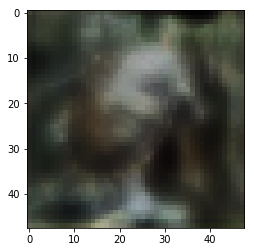

300it [01:21,  3.57it/s]

Epoch:  11 | train loss: 0.0051
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

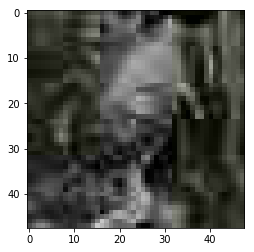

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

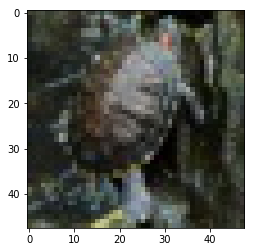

tensor([[[0.2549, 0.2084, 0.2510,  ..., 0.2666, 0.2016, 0.2138],
         [0.1944, 0.1753, 0.2181,  ..., 0.2940, 0.2369, 0.2300],
         [0.1926, 0.1736, 0.2144,  ..., 0.3420, 0.2961, 0.2822],
         ...,
         [0.2592, 0.2126, 0.2036,  ..., 0.2001, 0.2152, 0.2291],
         [0.3053, 0.2602, 0.2664,  ..., 0.1962, 0.2207, 0.2196],
         [0.3794, 0.3562, 0.3547,  ..., 0.2172, 0.2509, 0.2755]],

        [[0.2559, 0.2063, 0.2530,  ..., 0.2663, 0.2030, 0.2033],
         [0.1931, 0.1900, 0.2349,  ..., 0.3281, 0.2538, 0.2278],
         [0.1933, 0.1913, 0.2342,  ..., 0.3721, 0.3155, 0.2870],
         ...,
         [0.2704, 0.2486, 0.2271,  ..., 0.2056, 0.2147, 0.2266],
         [0.3156, 0.3028, 0.2989,  ..., 0.2168, 0.2368, 0.2329],
         [0.4074, 0.3914, 0.3794,  ..., 0.2379, 0.2536, 0.2729]],

        [[0.2014, 0.1835, 0.2129,  ..., 0.2101, 0.1668, 0.1855],
         [0.1550, 0.1564, 0.1859,  ..., 0.2329, 0.1924, 0.1810],
         [0.1569, 0.1612, 0.1897,  ..., 0.2810, 0.2472, 0.

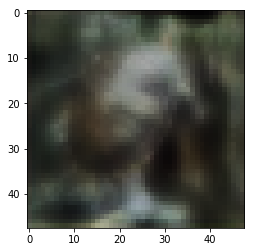

313it [01:25,  4.26it/s]
0it [00:00, ?it/s]

Epoch:  12 | train loss: 0.0061
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

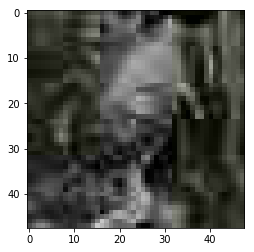

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

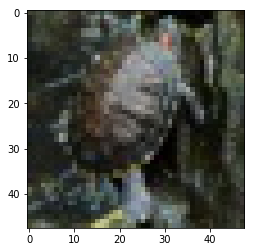

tensor([[[0.2549, 0.2085, 0.2511,  ..., 0.2667, 0.2017, 0.2139],
         [0.1945, 0.1753, 0.2181,  ..., 0.2942, 0.2370, 0.2302],
         [0.1926, 0.1736, 0.2144,  ..., 0.3422, 0.2963, 0.2824],
         ...,
         [0.2592, 0.2127, 0.2038,  ..., 0.2002, 0.2153, 0.2292],
         [0.3054, 0.2602, 0.2665,  ..., 0.1962, 0.2207, 0.2197],
         [0.3794, 0.3561, 0.3547,  ..., 0.2171, 0.2508, 0.2755]],

        [[0.2560, 0.2065, 0.2531,  ..., 0.2664, 0.2032, 0.2034],
         [0.1932, 0.1901, 0.2349,  ..., 0.3282, 0.2539, 0.2279],
         [0.1934, 0.1914, 0.2342,  ..., 0.3723, 0.3158, 0.2872],
         ...,
         [0.2705, 0.2488, 0.2272,  ..., 0.2057, 0.2147, 0.2267],
         [0.3157, 0.3029, 0.2991,  ..., 0.2169, 0.2368, 0.2329],
         [0.4074, 0.3914, 0.3794,  ..., 0.2378, 0.2535, 0.2729]],

        [[0.2014, 0.1836, 0.2129,  ..., 0.2101, 0.1669, 0.1856],
         [0.1549, 0.1564, 0.1858,  ..., 0.2329, 0.1924, 0.1811],
         [0.1568, 0.1611, 0.1896,  ..., 0.2809, 0.2472, 0.

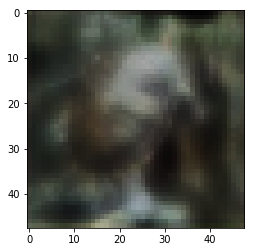

100it [00:27,  3.70it/s]

Epoch:  12 | train loss: 0.0066
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

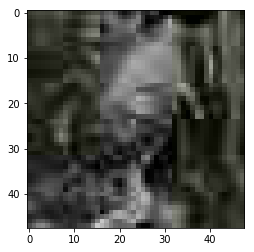

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

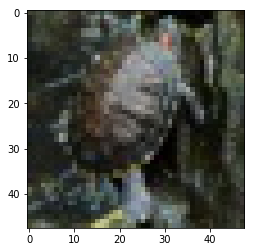

tensor([[[0.2551, 0.2087, 0.2513,  ..., 0.2667, 0.2018, 0.2140],
         [0.1946, 0.1756, 0.2184,  ..., 0.2943, 0.2372, 0.2303],
         [0.1928, 0.1739, 0.2148,  ..., 0.3425, 0.2966, 0.2826],
         ...,
         [0.2596, 0.2131, 0.2043,  ..., 0.2002, 0.2154, 0.2293],
         [0.3055, 0.2605, 0.2667,  ..., 0.1963, 0.2208, 0.2197],
         [0.3794, 0.3560, 0.3545,  ..., 0.2171, 0.2508, 0.2754]],

        [[0.2561, 0.2066, 0.2532,  ..., 0.2663, 0.2031, 0.2034],
         [0.1933, 0.1902, 0.2350,  ..., 0.3282, 0.2539, 0.2280],
         [0.1935, 0.1915, 0.2344,  ..., 0.3724, 0.3159, 0.2873],
         ...,
         [0.2710, 0.2495, 0.2280,  ..., 0.2058, 0.2148, 0.2268],
         [0.3160, 0.3034, 0.2996,  ..., 0.2170, 0.2369, 0.2329],
         [0.4074, 0.3914, 0.3794,  ..., 0.2379, 0.2536, 0.2729]],

        [[0.2016, 0.1838, 0.2131,  ..., 0.2101, 0.1669, 0.1856],
         [0.1552, 0.1567, 0.1862,  ..., 0.2331, 0.1925, 0.1812],
         [0.1571, 0.1615, 0.1901,  ..., 0.2813, 0.2474, 0.

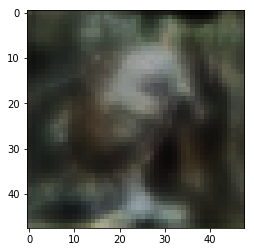

200it [00:54,  3.81it/s]

Epoch:  12 | train loss: 0.0060
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

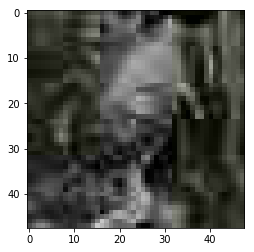

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

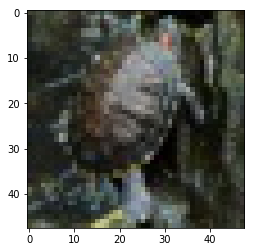

tensor([[[0.2549, 0.2086, 0.2513,  ..., 0.2666, 0.2016, 0.2138],
         [0.1945, 0.1755, 0.2184,  ..., 0.2942, 0.2370, 0.2300],
         [0.1927, 0.1738, 0.2147,  ..., 0.3423, 0.2963, 0.2822],
         ...,
         [0.2591, 0.2125, 0.2036,  ..., 0.1999, 0.2150, 0.2287],
         [0.3052, 0.2600, 0.2662,  ..., 0.1959, 0.2204, 0.2193],
         [0.3793, 0.3559, 0.3544,  ..., 0.2167, 0.2504, 0.2751]],

        [[0.2562, 0.2067, 0.2535,  ..., 0.2665, 0.2031, 0.2034],
         [0.1934, 0.1904, 0.2353,  ..., 0.3285, 0.2540, 0.2279],
         [0.1937, 0.1917, 0.2347,  ..., 0.3726, 0.3159, 0.2871],
         ...,
         [0.2707, 0.2491, 0.2275,  ..., 0.2059, 0.2148, 0.2265],
         [0.3159, 0.3032, 0.2993,  ..., 0.2170, 0.2368, 0.2327],
         [0.4074, 0.3915, 0.3794,  ..., 0.2378, 0.2535, 0.2727]],

        [[0.2014, 0.1836, 0.2130,  ..., 0.2099, 0.1667, 0.1854],
         [0.1550, 0.1564, 0.1859,  ..., 0.2327, 0.1922, 0.1809],
         [0.1569, 0.1613, 0.1897,  ..., 0.2808, 0.2469, 0.

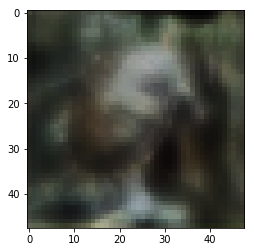

300it [01:21,  3.78it/s]

Epoch:  12 | train loss: 0.0056
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

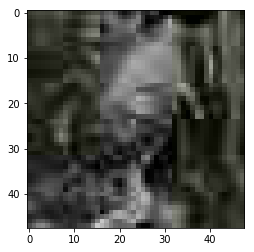

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

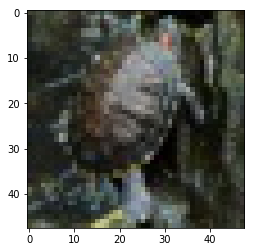

tensor([[[0.2543, 0.2079, 0.2506,  ..., 0.2661, 0.2012, 0.2134],
         [0.1941, 0.1750, 0.2179,  ..., 0.2937, 0.2365, 0.2297],
         [0.1925, 0.1735, 0.2142,  ..., 0.3418, 0.2959, 0.2819],
         ...,
         [0.2588, 0.2121, 0.2031,  ..., 0.1999, 0.2149, 0.2287],
         [0.3050, 0.2598, 0.2660,  ..., 0.1959, 0.2204, 0.2193],
         [0.3792, 0.3559, 0.3544,  ..., 0.2167, 0.2505, 0.2752]],

        [[0.2555, 0.2060, 0.2527,  ..., 0.2657, 0.2025, 0.2029],
         [0.1929, 0.1899, 0.2348,  ..., 0.3280, 0.2536, 0.2275],
         [0.1933, 0.1914, 0.2342,  ..., 0.3721, 0.3155, 0.2868],
         ...,
         [0.2701, 0.2483, 0.2267,  ..., 0.2057, 0.2147, 0.2264],
         [0.3154, 0.3026, 0.2987,  ..., 0.2169, 0.2367, 0.2327],
         [0.4073, 0.3913, 0.3792,  ..., 0.2377, 0.2534, 0.2727]],

        [[0.2009, 0.1830, 0.2125,  ..., 0.2095, 0.1663, 0.1851],
         [0.1546, 0.1561, 0.1855,  ..., 0.2325, 0.1920, 0.1807],
         [0.1567, 0.1609, 0.1894,  ..., 0.2806, 0.2468, 0.

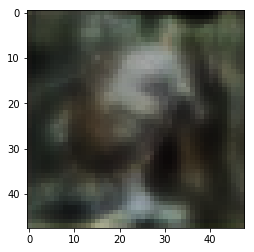

313it [01:25,  4.46it/s]
0it [00:00, ?it/s]

Epoch:  13 | train loss: 0.0051
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

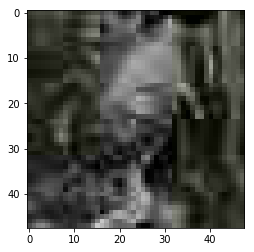

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

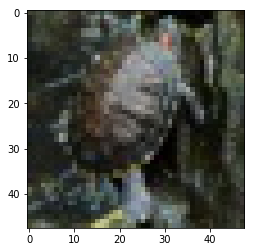

tensor([[[0.2545, 0.2081, 0.2508,  ..., 0.2661, 0.2012, 0.2134],
         [0.1943, 0.1752, 0.2181,  ..., 0.2938, 0.2366, 0.2298],
         [0.1926, 0.1736, 0.2144,  ..., 0.3420, 0.2960, 0.2820],
         ...,
         [0.2589, 0.2122, 0.2032,  ..., 0.2001, 0.2152, 0.2289],
         [0.3052, 0.2600, 0.2662,  ..., 0.1961, 0.2206, 0.2195],
         [0.3794, 0.3562, 0.3547,  ..., 0.2171, 0.2508, 0.2754]],

        [[0.2556, 0.2061, 0.2529,  ..., 0.2658, 0.2025, 0.2030],
         [0.1930, 0.1900, 0.2350,  ..., 0.3281, 0.2536, 0.2276],
         [0.1934, 0.1915, 0.2344,  ..., 0.3723, 0.3156, 0.2869],
         ...,
         [0.2702, 0.2485, 0.2268,  ..., 0.2059, 0.2148, 0.2266],
         [0.3155, 0.3028, 0.2989,  ..., 0.2171, 0.2369, 0.2328],
         [0.4074, 0.3915, 0.3795,  ..., 0.2379, 0.2536, 0.2729]],

        [[0.2010, 0.1833, 0.2127,  ..., 0.2097, 0.1664, 0.1852],
         [0.1548, 0.1563, 0.1859,  ..., 0.2329, 0.1922, 0.1808],
         [0.1569, 0.1612, 0.1898,  ..., 0.2811, 0.2472, 0.

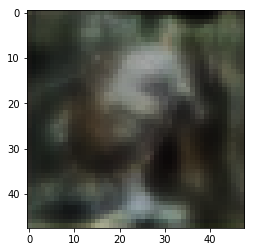

100it [00:26,  3.77it/s]

Epoch:  13 | train loss: 0.0059
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

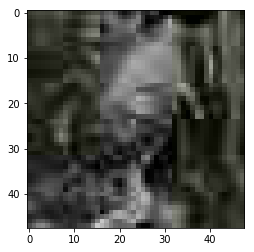

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

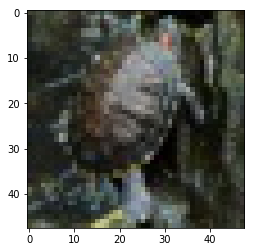

tensor([[[0.2547, 0.2083, 0.2510,  ..., 0.2660, 0.2011, 0.2133],
         [0.1944, 0.1753, 0.2182,  ..., 0.2936, 0.2365, 0.2296],
         [0.1927, 0.1737, 0.2146,  ..., 0.3418, 0.2958, 0.2818],
         ...,
         [0.2591, 0.2126, 0.2036,  ..., 0.1998, 0.2149, 0.2287],
         [0.3052, 0.2600, 0.2662,  ..., 0.1957, 0.2202, 0.2192],
         [0.3791, 0.3557, 0.3541,  ..., 0.2163, 0.2501, 0.2748]],

        [[0.2557, 0.2063, 0.2530,  ..., 0.2655, 0.2023, 0.2028],
         [0.1930, 0.1900, 0.2348,  ..., 0.3276, 0.2533, 0.2273],
         [0.1933, 0.1914, 0.2342,  ..., 0.3718, 0.3151, 0.2866],
         ...,
         [0.2703, 0.2487, 0.2270,  ..., 0.2055, 0.2144, 0.2263],
         [0.3155, 0.3027, 0.2988,  ..., 0.2164, 0.2363, 0.2324],
         [0.4071, 0.3910, 0.3789,  ..., 0.2370, 0.2528, 0.2723]],

        [[0.2011, 0.1833, 0.2127,  ..., 0.2093, 0.1662, 0.1850],
         [0.1548, 0.1562, 0.1856,  ..., 0.2322, 0.1917, 0.1805],
         [0.1568, 0.1610, 0.1895,  ..., 0.2803, 0.2465, 0.

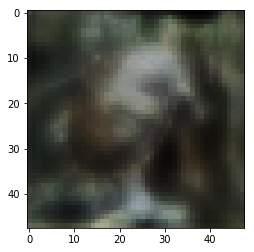

200it [00:54,  3.77it/s]

Epoch:  13 | train loss: 0.0060
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

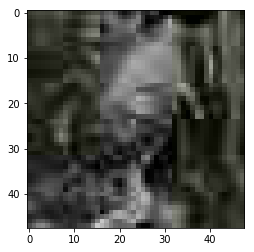

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

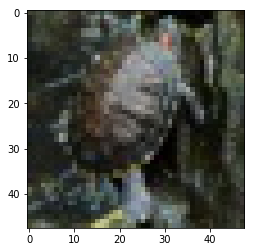

tensor([[[0.2543, 0.2080, 0.2509,  ..., 0.2660, 0.2011, 0.2133],
         [0.1942, 0.1752, 0.2183,  ..., 0.2939, 0.2367, 0.2297],
         [0.1926, 0.1738, 0.2147,  ..., 0.3422, 0.2962, 0.2819],
         ...,
         [0.2589, 0.2123, 0.2033,  ..., 0.2000, 0.2151, 0.2288],
         [0.3050, 0.2599, 0.2661,  ..., 0.1958, 0.2202, 0.2192],
         [0.3791, 0.3558, 0.3543,  ..., 0.2163, 0.2500, 0.2748]],

        [[0.2555, 0.2062, 0.2532,  ..., 0.2657, 0.2024, 0.2029],
         [0.1930, 0.1902, 0.2353,  ..., 0.3283, 0.2538, 0.2276],
         [0.1935, 0.1918, 0.2348,  ..., 0.3727, 0.3158, 0.2869],
         ...,
         [0.2704, 0.2489, 0.2273,  ..., 0.2062, 0.2150, 0.2266],
         [0.3156, 0.3031, 0.2992,  ..., 0.2170, 0.2368, 0.2326],
         [0.4073, 0.3913, 0.3793,  ..., 0.2373, 0.2530, 0.2724]],

        [[0.2008, 0.1830, 0.2125,  ..., 0.2092, 0.1661, 0.1849],
         [0.1546, 0.1560, 0.1856,  ..., 0.2323, 0.1917, 0.1805],
         [0.1567, 0.1610, 0.1895,  ..., 0.2806, 0.2466, 0.

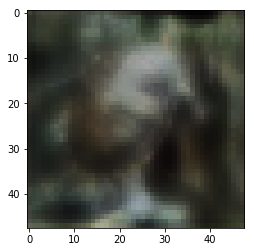

300it [01:21,  3.78it/s]

Epoch:  13 | train loss: 0.0061
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

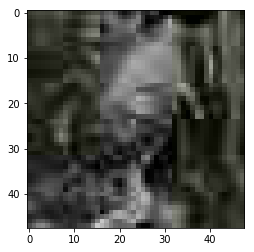

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

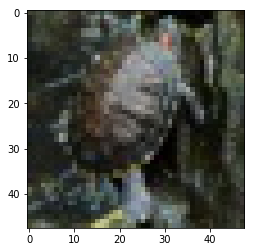

tensor([[[0.2543, 0.2080, 0.2508,  ..., 0.2661, 0.2013, 0.2136],
         [0.1941, 0.1751, 0.2180,  ..., 0.2939, 0.2369, 0.2301],
         [0.1924, 0.1734, 0.2142,  ..., 0.3421, 0.2963, 0.2823],
         ...,
         [0.2587, 0.2122, 0.2033,  ..., 0.1998, 0.2150, 0.2289],
         [0.3048, 0.2597, 0.2659,  ..., 0.1959, 0.2205, 0.2194],
         [0.3789, 0.3556, 0.3540,  ..., 0.2167, 0.2505, 0.2751]],

        [[0.2557, 0.2063, 0.2532,  ..., 0.2658, 0.2026, 0.2031],
         [0.1931, 0.1901, 0.2350,  ..., 0.3284, 0.2540, 0.2280],
         [0.1935, 0.1916, 0.2344,  ..., 0.3727, 0.3161, 0.2875],
         ...,
         [0.2704, 0.2490, 0.2275,  ..., 0.2062, 0.2151, 0.2269],
         [0.3156, 0.3031, 0.2993,  ..., 0.2174, 0.2372, 0.2331],
         [0.4072, 0.3913, 0.3792,  ..., 0.2380, 0.2536, 0.2729]],

        [[0.2008, 0.1830, 0.2124,  ..., 0.2093, 0.1662, 0.1852],
         [0.1545, 0.1559, 0.1853,  ..., 0.2324, 0.1919, 0.1809],
         [0.1565, 0.1608, 0.1891,  ..., 0.2805, 0.2468, 0.

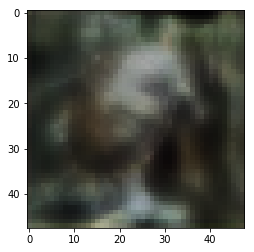

313it [01:26,  4.48it/s]
0it [00:00, ?it/s]

Epoch:  14 | train loss: 0.0066
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

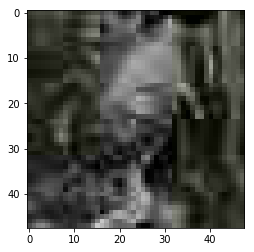

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

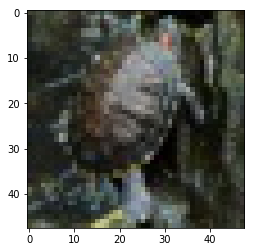

tensor([[[0.2541, 0.2078, 0.2507,  ..., 0.2659, 0.2010, 0.2133],
         [0.1941, 0.1751, 0.2180,  ..., 0.2938, 0.2366, 0.2297],
         [0.1924, 0.1735, 0.2143,  ..., 0.3420, 0.2960, 0.2820],
         ...,
         [0.2587, 0.2121, 0.2031,  ..., 0.1998, 0.2149, 0.2287],
         [0.3048, 0.2597, 0.2659,  ..., 0.1959, 0.2204, 0.2193],
         [0.3790, 0.3557, 0.3542,  ..., 0.2168, 0.2505, 0.2751]],

        [[0.2554, 0.2060, 0.2529,  ..., 0.2654, 0.2022, 0.2028],
         [0.1928, 0.1900, 0.2349,  ..., 0.3281, 0.2536, 0.2276],
         [0.1933, 0.1915, 0.2343,  ..., 0.3724, 0.3157, 0.2870],
         ...,
         [0.2702, 0.2487, 0.2271,  ..., 0.2061, 0.2149, 0.2266],
         [0.3154, 0.3029, 0.2990,  ..., 0.2172, 0.2370, 0.2328],
         [0.4072, 0.3913, 0.3793,  ..., 0.2379, 0.2535, 0.2728]],

        [[0.2006, 0.1829, 0.2124,  ..., 0.2091, 0.1660, 0.1849],
         [0.1545, 0.1559, 0.1854,  ..., 0.2323, 0.1918, 0.1806],
         [0.1566, 0.1609, 0.1892,  ..., 0.2806, 0.2467, 0.

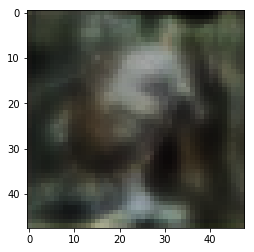

100it [00:27,  3.82it/s]

Epoch:  14 | train loss: 0.0056
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

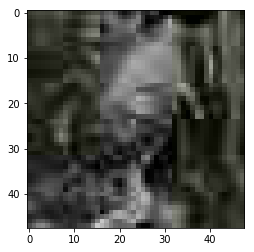

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

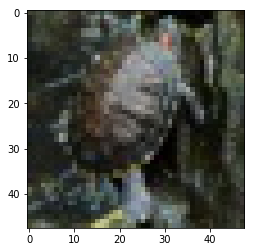

tensor([[[0.2543, 0.2081, 0.2512,  ..., 0.2662, 0.2012, 0.2135],
         [0.1945, 0.1756, 0.2187,  ..., 0.2943, 0.2370, 0.2299],
         [0.1929, 0.1741, 0.2150,  ..., 0.3426, 0.2965, 0.2822],
         ...,
         [0.2591, 0.2125, 0.2033,  ..., 0.2002, 0.2152, 0.2288],
         [0.3052, 0.2601, 0.2662,  ..., 0.1962, 0.2206, 0.2194],
         [0.3793, 0.3561, 0.3546,  ..., 0.2169, 0.2507, 0.2752]],

        [[0.2555, 0.2061, 0.2532,  ..., 0.2655, 0.2023, 0.2028],
         [0.1931, 0.1902, 0.2353,  ..., 0.3285, 0.2539, 0.2277],
         [0.1937, 0.1918, 0.2347,  ..., 0.3728, 0.3159, 0.2871],
         ...,
         [0.2704, 0.2488, 0.2270,  ..., 0.2063, 0.2151, 0.2266],
         [0.3156, 0.3031, 0.2991,  ..., 0.2175, 0.2371, 0.2328],
         [0.4074, 0.3915, 0.3794,  ..., 0.2380, 0.2536, 0.2728]],

        [[0.2006, 0.1829, 0.2125,  ..., 0.2092, 0.1660, 0.1850],
         [0.1546, 0.1561, 0.1856,  ..., 0.2327, 0.1920, 0.1807],
         [0.1568, 0.1611, 0.1894,  ..., 0.2809, 0.2469, 0.

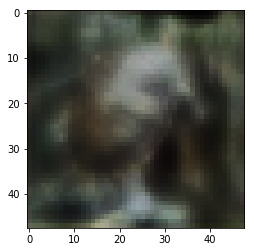

200it [00:54,  3.69it/s]

Epoch:  14 | train loss: 0.0063
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

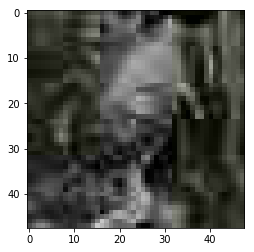

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

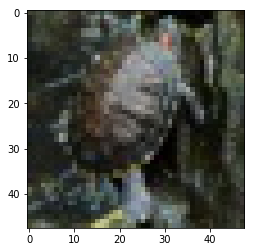

tensor([[[0.2545, 0.2083, 0.2513,  ..., 0.2657, 0.2008, 0.2132],
         [0.1945, 0.1756, 0.2187,  ..., 0.2937, 0.2365, 0.2295],
         [0.1929, 0.1741, 0.2150,  ..., 0.3421, 0.2959, 0.2817],
         ...,
         [0.2590, 0.2124, 0.2033,  ..., 0.1998, 0.2149, 0.2286],
         [0.3050, 0.2599, 0.2660,  ..., 0.1957, 0.2201, 0.2190],
         [0.3790, 0.3557, 0.3541,  ..., 0.2163, 0.2500, 0.2747]],

        [[0.2558, 0.2065, 0.2535,  ..., 0.2653, 0.2020, 0.2026],
         [0.1932, 0.1904, 0.2355,  ..., 0.3282, 0.2536, 0.2274],
         [0.1937, 0.1920, 0.2349,  ..., 0.3727, 0.3157, 0.2869],
         ...,
         [0.2704, 0.2490, 0.2273,  ..., 0.2063, 0.2151, 0.2266],
         [0.3155, 0.3030, 0.2991,  ..., 0.2172, 0.2368, 0.2326],
         [0.4072, 0.3912, 0.3792,  ..., 0.2375, 0.2531, 0.2724]],

        [[0.2009, 0.1832, 0.2128,  ..., 0.2091, 0.1659, 0.1848],
         [0.1547, 0.1562, 0.1858,  ..., 0.2324, 0.1917, 0.1805],
         [0.1569, 0.1612, 0.1897,  ..., 0.2808, 0.2467, 0.

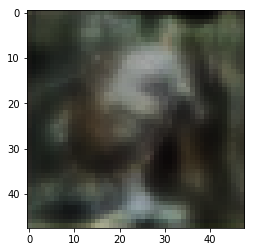

300it [01:24,  3.55it/s]

Epoch:  14 | train loss: 0.0062
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

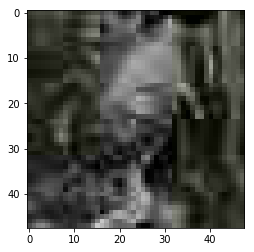

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

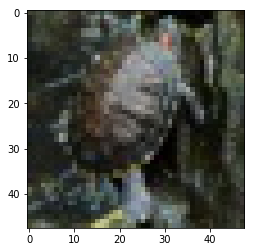

tensor([[[0.2545, 0.2085, 0.2514,  ..., 0.2658, 0.2010, 0.2133],
         [0.1946, 0.1758, 0.2189,  ..., 0.2941, 0.2369, 0.2298],
         [0.1929, 0.1743, 0.2153,  ..., 0.3426, 0.2965, 0.2821],
         ...,
         [0.2592, 0.2129, 0.2039,  ..., 0.2002, 0.2153, 0.2289],
         [0.3051, 0.2602, 0.2664,  ..., 0.1960, 0.2205, 0.2193],
         [0.3789, 0.3556, 0.3540,  ..., 0.2165, 0.2502, 0.2748]],

        [[0.2555, 0.2062, 0.2532,  ..., 0.2649, 0.2018, 0.2025],
         [0.1929, 0.1901, 0.2351,  ..., 0.3278, 0.2533, 0.2275],
         [0.1934, 0.1916, 0.2344,  ..., 0.3723, 0.3155, 0.2869],
         ...,
         [0.2702, 0.2490, 0.2273,  ..., 0.2059, 0.2148, 0.2265],
         [0.3153, 0.3028, 0.2989,  ..., 0.2168, 0.2366, 0.2326],
         [0.4069, 0.3908, 0.3787,  ..., 0.2372, 0.2528, 0.2722]],

        [[0.2007, 0.1830, 0.2125,  ..., 0.2088, 0.1657, 0.1848],
         [0.1546, 0.1560, 0.1854,  ..., 0.2321, 0.1915, 0.1805],
         [0.1566, 0.1609, 0.1893,  ..., 0.2804, 0.2465, 0.

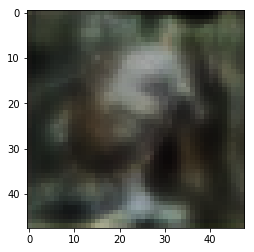

313it [01:28,  4.13it/s]
0it [00:00, ?it/s]

Epoch:  15 | train loss: 0.0058
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.2627, 0.2863,  ..., 0.2667, 0.2431, 0.0863],
         [0.1922, 0.2235, 0.2471,  ..., 0.2824, 0.2784, 0.1294],
         [0.1490, 0.1804, 0.2118,  ..., 0.3059, 0.3294, 0.1922],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2275, 0.2157, 0.1922],
         [0.1804, 0.2549, 0.3333,  ..., 0.2275, 0.2353, 0.2235],
         [0.2980, 0.4000, 0.5098,  ..., 0.2275, 0.2471, 0.2471]],

        [[0.2431, 0.2706, 0.2941,  ..., 0.2745, 0.2510, 0.0941],
         [0.2000, 0.2314, 0.2549,  ..., 0.2902, 0.2863, 0.1373],
         [0.1569, 0.1882, 0.2196,  ..., 0.3137, 0.3373, 0.2000],
         ...,
         [0.1412, 0.1647, 0.1843,  ..., 0.2353, 0.2235, 0.2000],
         [0.1804, 0.2549, 0.3333,  ..., 0.2353, 0.2431, 0.2314],
         [0.2980, 0.4000, 0.5098,  ..., 0.2353, 0.2549, 0.2549]],

        [[0.2000, 0.2275, 0.2510,  ..., 0.2314, 0.2078, 0.0510],
         [0.1569, 0.1882, 0.2118,  ..., 0.2471, 0.2431, 0.0941],

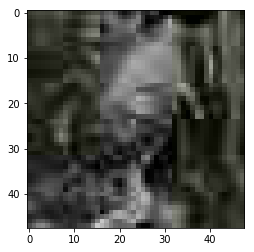

tensor([[[0.2510, 0.2314, 0.2784,  ..., 0.3059, 0.1961, 0.1451],
         [0.1373, 0.1882, 0.2471,  ..., 0.3294, 0.1922, 0.1804],
         [0.1294, 0.1843, 0.2745,  ..., 0.3961, 0.2784, 0.2157],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.1882, 0.2275, 0.2392],
         [0.2392, 0.2510, 0.3333,  ..., 0.2000, 0.2549, 0.1608],
         [0.2745, 0.3804, 0.4196,  ..., 0.1961, 0.2784, 0.2078]],

        [[0.2588, 0.2471, 0.2941,  ..., 0.2980, 0.1765, 0.1176],
         [0.1412, 0.2000, 0.2627,  ..., 0.3216, 0.1725, 0.1569],
         [0.1373, 0.1961, 0.2863,  ..., 0.4039, 0.2706, 0.2039],
         ...,
         [0.1882, 0.1843, 0.1765,  ..., 0.1961, 0.2275, 0.2392],
         [0.2549, 0.2784, 0.3569,  ..., 0.2078, 0.2627, 0.1686],
         [0.2941, 0.4000, 0.4314,  ..., 0.2078, 0.2863, 0.2157]],

        [[0.2078, 0.1922, 0.2392,  ..., 0.2078, 0.1020, 0.0549],
         [0.1098, 0.1569, 0.2078,  ..., 0.2314, 0.0980, 0.0941],
         [0.1176, 0.1686, 0.2431,  ..., 0.3098, 0.1882, 0.

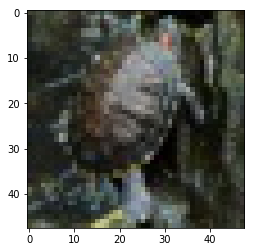

tensor([[[0.2545, 0.2085, 0.2514,  ..., 0.2659, 0.2010, 0.2133],
         [0.1946, 0.1759, 0.2191,  ..., 0.2943, 0.2370, 0.2299],
         [0.1930, 0.1744, 0.2154,  ..., 0.3428, 0.2966, 0.2822],
         ...,
         [0.2593, 0.2130, 0.2040,  ..., 0.2005, 0.2155, 0.2291],
         [0.3053, 0.2604, 0.2666,  ..., 0.1964, 0.2208, 0.2195],
         [0.3793, 0.3562, 0.3547,  ..., 0.2170, 0.2506, 0.2751]],

        [[0.2554, 0.2061, 0.2530,  ..., 0.2648, 0.2017, 0.2025],
         [0.1929, 0.1901, 0.2350,  ..., 0.3278, 0.2533, 0.2274],
         [0.1934, 0.1916, 0.2345,  ..., 0.3724, 0.3155, 0.2869],
         ...,
         [0.2702, 0.2488, 0.2272,  ..., 0.2060, 0.2148, 0.2265],
         [0.3153, 0.3029, 0.2990,  ..., 0.2170, 0.2367, 0.2326],
         [0.4071, 0.3912, 0.3791,  ..., 0.2375, 0.2531, 0.2724]],

        [[0.2008, 0.1832, 0.2127,  ..., 0.2090, 0.1658, 0.1848],
         [0.1548, 0.1563, 0.1859,  ..., 0.2325, 0.1918, 0.1807],
         [0.1569, 0.1613, 0.1898,  ..., 0.2811, 0.2469, 0.

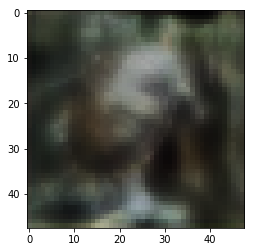

23it [00:07,  3.58it/s]


KeyboardInterrupt: ignored

In [8]:
in_data, original_data = train_dataset.get_train_data(n_plots)
autoencoder = ConvAutoencoder()
# rednet = REDNet10()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = loss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6,9], gamma=0.1)

for epoch in range(epochs):
    autoencoder.train()
    for step, (x, y) in tqdm.tqdm(enumerate(train_loader)):

        encoded, decoded = autoencoder(x) 
#         decoded = rednet(x)
        loss = loss_func(decoded, y)
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 100 == 0:# and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())
#             decoded_data = rednet(original_data)
            _, decoded_data = autoencoder(original_data)
            print(in_data.shape)
            show_img(in_data.squeeze(0))
            show_img(original_data.squeeze(0))
            show_img(decoded_data.data.squeeze(0))
          
    scheduler.step()

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0275, 0.0275],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0353, 0.0353, 0.0314,  ..., 0.0039, 0.0039, 0.0000],
         ...,
         [0.0157, 0.0157, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0353, 0.0353, 0.0314,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0196, 0.0196, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0118, 0.0118],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0549, 0.0627, 0.0627],
         [0.0000, 0.0000, 0.0000,  ..., 0.0353, 0.0353, 0.0353],
         [0.0275, 0.0275, 0.0235,  ..., 0.0392, 0.0392, 0.

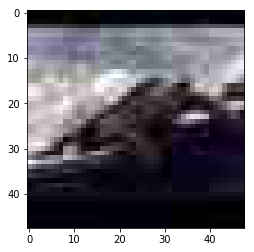

tensor([[[1.1796e-02, 1.3477e-03, 7.8938e-04,  ..., 1.1015e-03,
          2.4934e-03, 1.7053e-02],
         [2.9425e-02, 7.8434e-03, 5.6280e-03,  ..., 7.1454e-03,
          1.5526e-02, 4.5184e-02],
         [1.1309e-01, 7.0424e-02, 6.4517e-02,  ..., 7.6342e-02,
          1.2173e-01, 1.9386e-01],
         ...,
         [3.6295e-03, 4.5924e-04, 2.8223e-04,  ..., 6.8781e-04,
          1.2380e-03, 3.3108e-03],
         [4.9720e-03, 7.0789e-04, 4.2732e-04,  ..., 8.1244e-04,
          1.5547e-03, 4.0595e-03],
         [1.8878e-02, 4.4996e-03, 2.8845e-03,  ..., 3.8877e-03,
          6.5447e-03, 1.5334e-02]],

        [[9.5937e-03, 1.0504e-03, 5.6396e-04,  ..., 6.1561e-04,
          1.4020e-03, 1.2212e-02],
         [2.0037e-02, 6.0837e-03, 3.7775e-03,  ..., 4.9553e-03,
          1.0497e-02, 3.5187e-02],
         [9.7413e-02, 6.2472e-02, 5.1000e-02,  ..., 6.0551e-02,
          9.7764e-02, 1.7285e-01],
         ...,
         [1.5800e-03, 2.0308e-04, 9.6523e-05,  ..., 3.1487e-04,
          5.867

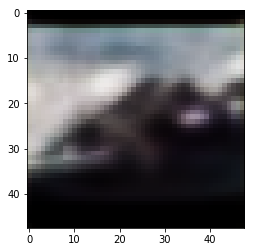

In [9]:
test_dataset = DenoisingDataset('data', 
                                train=False,
                                transform=transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                ]))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
decoded_samples = []
autoencoder.eval()
for step, x in enumerate(test_loader): 
    _,de_x = autoencoder(x)
    decoded_samples.append(de_x.detach().numpy())
    
sampled_z = np.concatenate(decoded_samples, axis=0)


def save_result(images: np.ndarray, out_path: str):
    assert images.shape == (400, 3, 48, 48)
    flat_img = images.reshape(400, -1)
    n_rows = np.prod(images.shape)
    
    y_with_id = np.concatenate([np.arange(n_rows).reshape(-1, 1), flat_img.reshape(n_rows, 1)], axis=1)
    np.savetxt(out_path, y_with_id, delimiter=",", fmt=['%d', '%.4f'], header="id,expetced", comments='')
    
save_result(sampled_z, 'solution.csv')
show_img(x[0].squeeze(0))
show_img(de_x[0].data.squeeze(0))
